In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import datetime
import tempfile
from qiime2 import Artifact
import zipfile
import yaml
%matplotlib inline
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

## Import and format metadata from lab, and BBMP

### import from Jenni

In [2]:
files = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/20**/METADATA.txt')

In [3]:
def load_df(filenames):
    md = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t')
        md.append(df)
        print (filename)
    return md

In [4]:
#load all metadata and concatenate them into one dataframe
md = load_df(files)
md = pd.concat(md)

/Users/Diana/Documents/escuela/phd/ch2/bb_data/2014/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2015/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2017/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2019/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2021/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2020/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2018/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2016/METADATA.txt


In [5]:
#drop empty columns and rows
md.dropna(how='all', axis=1, inplace=True) #empty cols
md.dropna(how='all', inplace=True) #empty rows

In [6]:
#check all columns
md.columns.values 

array(['sampleid', 'year', 'date', 'weekn', 'depth', 'depth_code',
       'date_depth', '[DNA]ng/uL', 'A260/280', 'extraction_date',
       'extracted_by', 'Sequenced', 'IMR_n', 'elutin_volume', 'nifH',
       'MetaG', 'new_id', 'notes', 'elution_volume', 'Unnamed: 15',
       '16S V6V8\nIMR #', 'Notes', 'BR Working Code (Top of Tube)',
       'Label on side of Tube', 'H2O Vol Filtered', 'size_code',
       'IMR # - V4V5', 'IMR # - 18S', 'Elution volume', 'Correct Week #',
       'Sequencing Code\nBBYear.WeekDepthSize', 'Freezer Box', 'Aliquots',
       '[DNA]ng/ul', 'Freezer Box (1.5mL)', 'Filtration Volume (DNA) ',
       'sample_code'], dtype=object)

#### Renumber dates

In [7]:
#create a dictionary for months
month_dic = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}

In [8]:
#add month to a new column
md['month_name'] = md['date'].str.split('-').str[1]

In [9]:
#add month number
md['month']= md['month_name'].map(month_dic)

In [10]:
#add day number
md['day'] = md['date'].str.split('-').str[0]

In [11]:
md[["year", "month", "day"]] = md[["year", "month", "day"]].apply(pd.to_numeric)

In [12]:
#remove symbol for better handling of data
#md.rename(columns={"Week#": "Weekn"}, inplace=True)
#md.rename(columns={"Depth": "depth"}, inplace=True) #to match dfo

In [13]:
#change to int to remove decimals from date columns
md.year = md.year.apply(int)
md.depth = md.depth.apply(int)
md.weekn = md.weekn.apply(int)

In [14]:
#change to str to aggregate them into time_string to match dfos formatting of the date
md.year = md.year.apply(str)
md.month = md.month.apply(str)
md.day = md.day.apply(str)
#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

In [15]:
#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

In [16]:
md['time_string'] = md[['year', 'month', 'day']].agg('-'.join, axis=1)

In [17]:
md

sampleid  year    date  weekn  depth depth_code date_depth  [DNA]ng/uL  A260/280 extraction_date extracted_by Sequenced IMR_n  elutin_volume nifH MetaG    new_id notes  elution_volume Unnamed: 15  16S V6V8\nIMR # Notes  BR Working Code (Top of Tube) Label on side of Tube H2O Vol Filtered size_code IMR # - V4V5 IMR # - 18S  Elution volume  Correct Week # Sequencing Code\nBBYear.WeekDepthSize Freezer Box Aliquots  [DNA]ng/ul Freezer Box (1.5mL)  Filtration Volume (DNA)  sample_code month_name month day time_string
0     BB14.3A  2014  15-Jan      3      1          A   01.15.1m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan    01  15  2014-01-15
1     BB14.3B  2014  15-Jan      3      5          B   01.15.5m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3B   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan    01  15  2014-01-15
2     BB14.3C  2014  15-Jan      3     10          C  01.15.10m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3C   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan    01  15  2014-01-15
3     BB14.3D  2014  15-Jan      3     60          D  01.15.60m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3D   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan    01  15  2014-01-15
4     BB14.4A  2014  23-Jan      4      1          A   01.23.1m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.4A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan    01  23  2014-01-23
..        ...   ...     ...    ...    ...        ...        ...         ...       ...             ...          ...       ...   ...            ...  ...   ...       ...   ...             ...         ...              ...   ...                            ...                   ...              ...       ...          ...         ...             ...             ...                                   ...         ...      ...         ...                 ...                       ...         ...        ...   ...  ..         ...
199  BB16.50D  2016  14-Dec     50     60          D        NaN        11.6      1.60      2017-01-23           CW       NaN   NaN            NaN    +   NaN  BB16.50D   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN

In [18]:
md.columns.values 

array(['sampleid', 'year', 'date', 'weekn', 'depth', 'depth_code',
       'date_depth', '[DNA]ng/uL', 'A260/280', 'extraction_date',
       'extracted_by', 'Sequenced', 'IMR_n', 'elutin_volume', 'nifH',
       'MetaG', 'new_id', 'notes', 'elution_volume', 'Unnamed: 15',
       '16S V6V8\nIMR #', 'Notes', 'BR Working Code (Top of Tube)',
       'Label on side of Tube', 'H2O Vol Filtered', 'size_code',
       'IMR # - V4V5', 'IMR # - 18S', 'Elution volume', 'Correct Week #',
       'Sequencing Code\nBBYear.WeekDepthSize', 'Freezer Box', 'Aliquots',
       '[DNA]ng/ul', 'Freezer Box (1.5mL)', 'Filtration Volume (DNA) ',
       'sample_code', 'month_name', 'month', 'day', 'time_string'],
      dtype=object)

### Import and manage BBMP data

#### Metadata __md__ is formatted. It contains 38 columns.
__md__ is the lab's metadata for sampling, extraction and sequencing. \
__dfo_md__ is BBMP remote sensing data (salinity, pH, temperature, density..) \
__bio_niskin__ contains nutrient data

In [19]:
dfo_md = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/bbmp_aggregated_profiles.csv")
bio_niskin = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/BBMP_Data_2022.csv")#
#dfo_metadata_y14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/data_export/trim-analysis/dfo_metadata_y14.tsv", sep='\t')

Format __bio_niskin__ data to merge with __md__. __bio_niskin__ is 32 columns, including year, month, day, and depth. __dfo_md__ also has 32 columns, including year_time, month_time, day_time. To merge these data with __md__, we will change the time stamps columns to the same name, and generate a time_string column.

In [20]:
dfo_md.columns.values

array(['time_string', 'year_time', 'month_time', 'day_time', 'julian_day',
       'scan', 'pressure', 'temperature', 'conductivity', 'oxygenVoltage',
       'fluorescence', 'unknown', 'pH', 'PSAR', 'salinity', 'theta',
       'sigmaTheta', 'oxygen', 'scan2', 'fluorescence2', 'turbidity',
       'oxygenCurrent', 'oxygenTemperature', 'oxygenSaturation',
       'unknown2', 'altimeter', 'sigmaTheta2', 'VOLT', 'depth',
       'fluorometer', 'par', 'flagArchaic'], dtype=object)

In [21]:
bio_niskin.columns.values

array(['mission_descriptor', 'event_id', 'sample_id', 'latitude',
       'longitude', 'year', 'month', 'day', 'time', 'depth',
       'Chlorophyll A', 'Nitrate', 'Nitrite', 'Phosphate', 'Silicate',
       'Ammonia', 'Salinity', 'Temperature', 'HPLC_ALLOX', 'HPLC_BUT19',
       'HPLC_CHLA', 'HPLC_CHLB', 'HPLC_CHLC12', 'HPLC_CHLC3',
       'HPLC_DIADINOX', 'HPLC_DIATOX', 'HPLC_FUCOX', 'HPLC_HEX19',
       'HPLC_PERID', 'HPLC_ZEA', 'POC', 'PON'], dtype=object)

In [22]:
#change to str to aggregate them into time_string
bio_niskin.year = bio_niskin.year.apply(str)
bio_niskin.month = bio_niskin.month.apply(str)
bio_niskin.day = bio_niskin.day.apply(str)
#add leading zero to match date format in dfo metadata
bio_niskin['month'] = bio_niskin['month'].str.zfill(2)
bio_niskin['day'] = bio_niskin['day'].str.zfill(2)

In [23]:
bio_niskin['time_string'] = bio_niskin[['year', 'month', 'day']].agg('-'.join, axis=1)

In [24]:
#sanity check to make sure everything is working so far
print(bio_niskin['month'].to_string(index=False))

 01
 01
 01
 01
 01
 01
 01
 01
 01
 01
 01
 01
 02
 02
 02
 02
 02
 02
 02
 02
 02
 02
 02
 02
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 06
 06
 06
 06
 06
 06
 06
 06
 06
 06
 06
 06
 06
 06
 06
 07
 07
 07
 07
 07
 07
 07
 07
 07
 07
 07
 07
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08
 09
 09
 09
 09
 09
 09
 09
 09
 09
 09
 09
 09
 09
 09
 09
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 11
 11
 11
 11
 11
 11
 11
 11
 11
 11
 11
 11
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 01
 01
 01
 01
 01
 01
 01
 01
 01
 01
 01
 01
 02
 02
 02
 02
 02
 02
 02
 02
 02
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 03
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 04
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 05
 06
 06
 06
 06
 06
 06
 06
 06
 06
 07
 07
 07
 07
 07
 07
 07
 07
 07
 07
 07
 07
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08
 08


In [25]:
#make a new column for time_string without the time
dfo_md['time_string_time'] = dfo_md['time_string']
dfo_md['time_string'] = dfo_md['time_string'].str.split(' ').str[0]

### Renaming party to ensure correct merging of metadata

In [26]:
dfo_md.columns.values 

array(['time_string', 'year_time', 'month_time', 'day_time', 'julian_day',
       'scan', 'pressure', 'temperature', 'conductivity', 'oxygenVoltage',
       'fluorescence', 'unknown', 'pH', 'PSAR', 'salinity', 'theta',
       'sigmaTheta', 'oxygen', 'scan2', 'fluorescence2', 'turbidity',
       'oxygenCurrent', 'oxygenTemperature', 'oxygenSaturation',
       'unknown2', 'altimeter', 'sigmaTheta2', 'VOLT', 'depth',
       'fluorometer', 'par', 'flagArchaic', 'time_string_time'],
      dtype=object)

In [27]:
bio_niskin.columns.values 

array(['mission_descriptor', 'event_id', 'sample_id', 'latitude',
       'longitude', 'year', 'month', 'day', 'time', 'depth',
       'Chlorophyll A', 'Nitrate', 'Nitrite', 'Phosphate', 'Silicate',
       'Ammonia', 'Salinity', 'Temperature', 'HPLC_ALLOX', 'HPLC_BUT19',
       'HPLC_CHLA', 'HPLC_CHLB', 'HPLC_CHLC12', 'HPLC_CHLC3',
       'HPLC_DIADINOX', 'HPLC_DIATOX', 'HPLC_FUCOX', 'HPLC_HEX19',
       'HPLC_PERID', 'HPLC_ZEA', 'POC', 'PON', 'time_string'],
      dtype=object)

In [28]:
dfo_md.rename(columns={"depth":"bbmpdepth","pressure": "depth", "year_time": "year", "month_time": "month", "day_time": "day"}, inplace=True)

In [29]:
#dfo_md.rename(columns={"pressure": "Depth", "year_time": "Year", "month_time":"Month", "day_time": "Date"}, inplace=True)

## Merging party

In [30]:
#change to int to remove decimals from date columns
md.year = md.year.apply(int)
md.depth = md.depth.apply(int)
md.weekn = md.weekn.apply(int)
md.month = md.month.apply(int)
md.day = md.day.apply(int)

In [31]:
#change to int to remove decimals from date columns
dfo_md.year = dfo_md.year.apply(int)
dfo_md.depth = dfo_md.depth.apply(int)
dfo_md.month = dfo_md.month.apply(int)
dfo_md.day = dfo_md.day.apply(int)

In [32]:
#change to int to remove decimals from date columns
bio_niskin.year = bio_niskin.year.apply(int)
bio_niskin.depth = bio_niskin.depth.apply(int)
bio_niskin.month = bio_niskin.month.apply(int)
bio_niskin.day = bio_niskin.day.apply(int)

In [33]:
merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")

In [34]:
allin = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")

In [35]:
merged.columns.values

array(['sampleid', 'year', 'date', 'weekn', 'depth', 'depth_code',
       'date_depth', '[DNA]ng/uL', 'A260/280', 'extraction_date',
       'extracted_by', 'Sequenced', 'IMR_n', 'elutin_volume', 'nifH',
       'MetaG', 'new_id', 'notes', 'elution_volume', 'Unnamed: 15',
       '16S V6V8\nIMR #', 'Notes', 'BR Working Code (Top of Tube)',
       'Label on side of Tube', 'H2O Vol Filtered', 'size_code',
       'IMR # - V4V5', 'IMR # - 18S', 'Elution volume', 'Correct Week #',
       'Sequencing Code\nBBYear.WeekDepthSize', 'Freezer Box', 'Aliquots',
       '[DNA]ng/ul', 'Freezer Box (1.5mL)', 'Filtration Volume (DNA) ',
       'sample_code', 'month_name', 'month', 'day', 'time_string_x',
       'time_string_y', 'julian_day', 'scan', 'temperature',
       'conductivity', 'oxygenVoltage', 'fluorescence', 'unknown', 'pH',
       'PSAR', 'salinity', 'theta', 'sigmaTheta', 'oxygen', 'scan2',
       'fluorescence2', 'turbidity', 'oxygenCurrent', 'oxygenTemperature',
       'oxygenSaturation', '

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



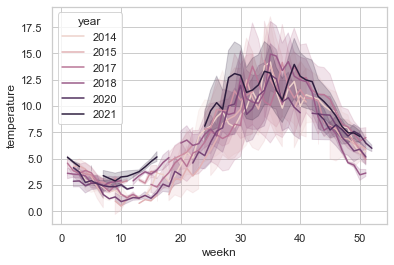

In [36]:
sns.lineplot(merged['weekn'],merged['temperature'], hue =merged["year"])

In [37]:
month_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Summer",
    "Sep": "Autumn",
    "Oct": "Autumn",
    "Nov": "Autumn",
    "Dec": "Winter"
}

merged['season'] = ''

for month, season in month_season.items():
    merged.loc[merged['month_name'] == month, 'season'] = season

year_season = merged.groupby(by = ['year','season']).mean().reset_index()

Winter = year_season.loc[year_season['season'] == 'Winter',:]
Spring = year_season.loc[year_season['season'] == 'Spring',:]
Summer = year_season.loc[year_season['season'] == 'Summer',:]
Autumn = year_season.loc[year_season['season'] == 'Autumn',:]

fig2 = go.Figure()
for template in ["plotly_white"]:
    fig2.add_trace(go.Scatter(x=Winter['year'], y=Winter['temperature'],
                    mode='lines',
                    name='Winter',
                    marker_color='#838B8B'))
    fig2.add_trace(go.Scatter(x=Spring['year'], y=Spring['temperature'],
                    mode='lines',
                    name='Spring',
                    marker_color='#FFB5C5'))
    fig2.add_trace(go.Scatter(x=Summer['year'], y=Summer['temperature'],
                    mode='lines',
                    name='Summer',
                    marker_color='#87CEFF'))
    fig2.add_trace(go.Scatter(x=Autumn['year'], y=Autumn['temperature'],
                    mode='lines',
                    name='Autumn',
                    marker_color='#FF8000'))
    fig2.update_layout(
    height=800,
    xaxis_title="Years",
    yaxis_title='Temperature in degree',
    title_text='Average Temperature seasonwise over the years',
    template=template)

fig2.show()

In [38]:
year_season

year  season      weekn      depth  [DNA]ng/uL  A260/280  elutin_volume  elution_volume  16S V6V8\nIMR #  BR Working Code (Top of Tube)  Elution volume  Correct Week #  [DNA]ng/ul  Filtration Volume (DNA)       month        day  julian_day         scan  temperature  conductivity  oxygenVoltage  fluorescence   unknown        pH        PSAR   salinity      theta  sigmaTheta    oxygen      scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic
0   2014  Autumn  42.000000  19.000000   55.062500  1.780500           50.0             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN  10.000000  14.692308  288.000000  2654.096154    10.215375      0.784421       2.035934      4.868725  0.361444       NaN   29.997696  30.309162        NaN   23.174420  4.856808        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN
1   2014  Spring  16.000000  18.774510    6.405319  2.746064          100.0             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN   4.000000  16.392157  106.079208  3038.821782     2.879282      0.638003       2.544265      4.156132  0.726430       NaN   59.899602  29.919447        NaN   23.815456  6.981725        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN
2   2014  Summer  29.000000  19.000000   47.203125  1.860312           50.0             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN   7.000000  15.538462  196.846154  3430.375000     9.727343      0.774376       2.422205      5.145293  1.164630       NaN   74.844147  30.267270        NaN   23.157111  6.238314        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN
3   2014  Winter  19.200000  19.000000    4.083333  1.838333          100.0             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN   4.700000  15.800000  128.400000  2847.850000     3.565734      0.647597       2.150690      1.834114  1.164065       NaN   27.442573  29.709958        NaN   23.590499  5.798310        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN
4   2015  Autumn  42.086957  19.000000   68.640789  1.738421            NaN             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN   9.956522  15.434783  288.300000  3312.437500     9.302704      0.759425       2.972832      4.624234       NaN       NaN   48.786751  29.972408        NaN   23.002001  4.926328        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN
..   ...     ...        ...        ...         ...       ...            ...             ...              ...                            ...             ...             ...         ...                       ...        ...        ...         ...          ...          ...           ...            ...           ...       ...       ...         ...        ...        ...         ...       ...        ...            ...        ...            ...                ...               ...       ...        ...          ...   ...        ...          ...  ...          ...
26  2020  Winter  20.694737  18.568421         NaN  1.647526            NaN         

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



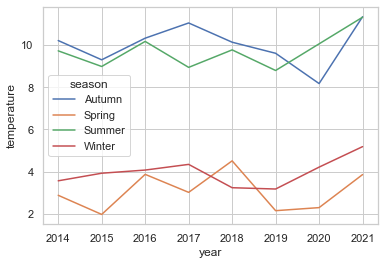

In [39]:
sns.lineplot(year_season['year'],year_season['temperature'], hue =year_season["season"])

In [40]:
plt.style.use('ggplot')

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



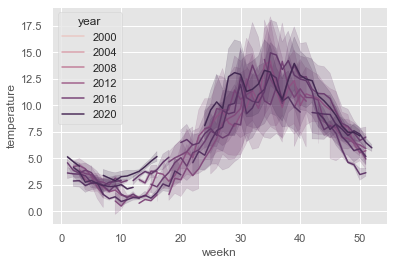

In [41]:
sns.lineplot(allin['weekn'],allin['temperature'], hue =allin["year"])

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



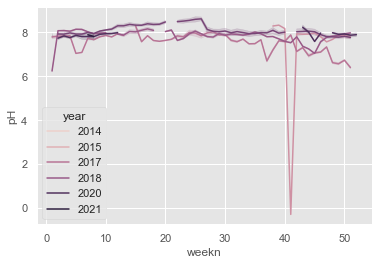

In [42]:
sns.lineplot(merged['weekn'],merged['pH'], hue =merged["year"])

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



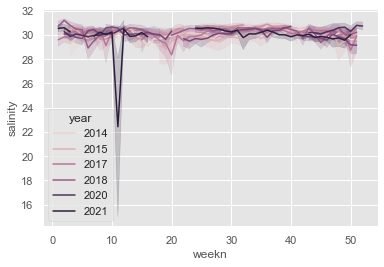

In [43]:
sns.lineplot(merged['weekn'],merged['salinity'], hue =merged["year"])

## Add nutrient data

In [44]:
all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")

In [45]:
all_md.columns

Index(['sampleid', 'year', 'date', 'weekn', 'depth', 'depth_code', 'date_depth', '[DNA]ng/uL', 'A260/280', 'extraction_date', 'extracted_by', 'Sequenced', 'IMR_n', 'elutin_volume', 'nifH', 'MetaG', 'new_id', 'notes', 'elution_volume', 'Unnamed: 15', '16S V6V8\nIMR #', 'Notes', 'BR Working Code (Top of Tube)', 'Label on side of Tube', 'H2O Vol Filtered', 'size_code', 'IMR # - V4V5', 'IMR # - 18S', 'Elution volume', 'Correct Week #', 'Sequencing Code\nBBYear.WeekDepthSize', 'Freezer Box', 'Aliquots', '[DNA]ng/ul', 'Freezer Box (1.5mL)', 'Filtration Volume (DNA) ', 'sample_code', 'month_name', 'month', 'day', 'time_string_x', 'time_string_y', 'julian_day', 'scan', 'temperature', 'conductivity', 'oxygenVoltage', 'fluorescence', 'unknown', 'pH', 'PSAR', 'salinity', 'theta', 'sigmaTheta', 'oxygen', 'scan2', 'fluorescence2', 'turbidity', 'oxygenCurrent', 'oxygenTemperature', 'oxygenSaturation', 'unknown2', 'altimeter', 'sigmaTheta2', 'VOLT', 'bbmpdepth', 'fluorometer', 'par', 'flagArchaic',
 

In [46]:
all_md

sampleid  year    date  weekn  depth depth_code date_depth  [DNA]ng/uL  A260/280 extraction_date extracted_by Sequenced IMR_n  elutin_volume nifH MetaG    new_id notes  elution_volume Unnamed: 15  16S V6V8\nIMR # Notes  BR Working Code (Top of Tube) Label on side of Tube H2O Vol Filtered size_code IMR # - V4V5 IMR # - 18S  Elution volume  Correct Week # Sequencing Code\nBBYear.WeekDepthSize Freezer Box Aliquots  [DNA]ng/ul Freezer Box (1.5mL)  Filtration Volume (DNA)  sample_code month_name  month  day time_string_x time_string_y  julian_day    scan  temperature  conductivity  oxygenVoltage  fluorescence  unknown     pH     PSAR  salinity  theta  sigmaTheta   oxygen  scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic     time_string_time  season mission_descriptor  event_id  sample_id  latitude  longitude    time  Chlorophyll A   Nitrate  Nitrite  Phosphate  \
0      BB14.3A  2014  15-Jan      3      1          A   01.15.1m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan      1   15    2014-01-15    2014-01-15        15.0  4189.0       3.6047      0.593479         2.4356        2.2421      NaN    NaN  26.6540   27.0224    NaN     21.4785  7.06001    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2014-01-15 13:08:32  Winter          18VA14667       2.0   387964.0   44.6917   -63.6417  1230.0        0.61000   9.00000  0.37000    0.82000   
1      BB14.3A  2014  15-Jan      3      1          A   01.15.1m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan      1   15    2014-01-15    2014-01-15        15.0  4168.0       3.5515      0.600981         2.4209        2.1548      NaN    NaN  16.9980   27.4422    NaN     21.8163  7.01872    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2014-01-15 13:08:32  Winter          18VA14667       2.0   387964.0   44.6917   -63.6417  1230.0        0.61000   9.00000  0.37000    0.82000   
2      BB14.3B  2014  15-Jan      3      5          B   01.15.5m         NaN       NaN             NaN          NaN       yes   NaN            NaN  NaN   NaN   BB14.3B   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Jan      1   15    2014-01-15    2014-01-15        15.0  4241.0       3.4460      0.627476         2.3669        2.0018      NaN    NaN   4.2959   28.8674    NaN     22.9584  6.80859    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2014-01-15 13:08:32  Winter          18VA14667       2.0   387963.0   44.6917   -63.6417  1230.0        0.49000   8.13000  0.26000    0.91000   
3      BB14.3B  2014  15-Jan  

In [47]:
'Chlorophyll A', 'Nitrate', 'Nitrite','Phosphate', 'Silicate', 'Ammonia', 'Salinity', 'Temperature','pH'

('Chlorophyll A',
 'Nitrate',
 'Nitrite',
 'Phosphate',
 'Silicate',
 'Ammonia',
 'Salinity',
 'Temperature',
 'pH')

In [48]:
all_md[all_md['Nitrate'].isna()]

sampleid  year    date  weekn  depth depth_code date_depth  [DNA]ng/uL  A260/280 extraction_date extracted_by Sequenced IMR_n  elutin_volume     nifH MetaG    new_id notes  elution_volume Unnamed: 15  16S V6V8\nIMR # Notes  BR Working Code (Top of Tube) Label on side of Tube H2O Vol Filtered size_code IMR # - V4V5 IMR # - 18S  Elution volume  Correct Week # Sequencing Code\nBBYear.WeekDepthSize Freezer Box Aliquots  [DNA]ng/ul Freezer Box (1.5mL)  Filtration Volume (DNA)  sample_code month_name  month  day time_string_x time_string_y  julian_day    scan  temperature  conductivity  oxygenVoltage  fluorescence  unknown  pH    PSAR  salinity  theta  sigmaTheta  oxygen  scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic     time_string_time  season mission_descriptor  event_id  sample_id  latitude  longitude    time  Chlorophyll A  Nitrate  Nitrite  Phosphate  \
438    BB15.8A  2015  18-Feb      8      1          A   02.19.1m        10.0      1.78   March 26 2015          NaN       NaN     x            NaN  BB15.8A   NaN   BB15.8A   NaN            50.0           +              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Feb      2   18    2015-02-18           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN NaN     NaN       NaN    NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN  Winter                NaN       NaN        NaN       NaN        NaN     NaN            NaN      NaN      NaN        NaN   
439    BB15.8B  2015  18-Feb      8      5          B   02.19.5m        19.4      1.74   March 26 2015          NaN       NaN     x            NaN  BB15.8B   NaN   BB15.8B   NaN            50.0           +              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Feb      2   18    2015-02-18           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN NaN     NaN       NaN    NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN  Winter                NaN       NaN        NaN       NaN        NaN     NaN            NaN      NaN      NaN        NaN   
440    BB15.8C  2015  18-Feb      8     10          C  02.19.10m        16.0      1.76   March 26 2015          NaN       NaN     x            NaN  BB15.8C   NaN   BB15.8C   NaN            50.0           +              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Feb      2   18    2015-02-18           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN NaN     NaN       NaN    NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN  Winter                NaN       NaN        NaN       NaN        NaN     NaN            NaN      NaN      NaN        NaN   
441    BB15.8D  2015  18-Feb      8   

In [49]:
shallow_depths = [1, 5, 10]

In [50]:
shallow = all_md[all_md["depth"] < 30]

In [51]:
shallow = shallow.groupby(['year', 'month', "day"]).mean().reset_index()

In [52]:
d1 = all_md[all_md.depth == 1]

In [53]:
deep = all_md[all_md.depth == 60]

## Plotting party

In [54]:
target_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [55]:
fig = px.line(shallow, x="weekn", y="salinity", color='year')
fig.show()

### Detect and plot anomalies in variables

In [56]:
shallow

year  month  day  weekn     depth  [DNA]ng/uL  A260/280  elutin_volume  elution_volume  16S V6V8\nIMR #  BR Working Code (Top of Tube)  Elution volume  Correct Week #  [DNA]ng/ul  Filtration Volume (DNA)   julian_day         scan  temperature  conductivity  oxygenVoltage  fluorescence   unknown  pH        PSAR   salinity      theta  sigmaTheta     oxygen      scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic  event_id  sample_id  latitude  longitude    time  Chlorophyll A   Nitrate   Nitrite  Phosphate   Silicate   Ammonia   Salinity  Temperature  HPLC_ALLOX  HPLC_BUT19  HPLC_CHLA  HPLC_CHLB  HPLC_CHLC12  HPLC_CHLC3  HPLC_DIADINOX  HPLC_DIATOX  HPLC_FUCOX  HPLC_HEX19  HPLC_PERID  HPLC_ZEA         POC        PON
0    2014      1   15    3.0  5.333333         NaN       NaN            NaN             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN        15.0  4247.833333     3.450683      0.621375       2.366133      2.041600       NaN NaN    9.084117  28.559017        NaN   22.712950   6.772503        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN       2.0   387963.0   44.6917   -63.6417  1230.0       0.550000  8.316667  0.286667   0.900000  12.550000  4.253333  28.470000     3.463333      0.0000         0.0   0.588000   0.048667     0.021667    0.000000       0.000000          0.0    0.091333         0.0    0.000000       0.0   206.10000   27.20000
1    2014      1   23    4.0  5.333333         NaN       NaN            NaN             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN        23.0  1891.333333     2.239000      0.614800       2.268433      1.805617  1.043468 NaN   49.348500  29.282833        NaN   23.371300   6.682290        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN       3.0   387967.0   44.6917   -63.6417  1230.0       0.590000  8.246667  0.246667   1.086667  10.973333  2.943333  29.233333     2.193333      0.0000         0.0   0.541000   0.014333     0.000000    0.000000       0.000000          0.0    0.046333         0.0    0.000000       0.0  2030.10000   51.50000
2    2014      1   29    5.0  5.333333         NaN       NaN            NaN             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN        29.0  2018.666667     1.960267      0.611040       3.475467      2.214433  3.092367 NaN    9.595950  29.359750        NaN   23.455500  11.282547        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN       4.0   387971.0   44.6917   -63.6417  1230.0       0.713333  8.526667  0.223333   1.070000  11.760000  2.983333  29.343333     1.933333      0.0000         0.0   0.615333   0.000000     0.092000    0.000000       0.000000          0.0    0.000000         0.0    0.000000       0.0   616.20000   42.40000
3    2014      2    4    6.0  5.333333         NaN       NaN            NaN             NaN              NaN                            NaN             NaN             NaN         NaN                       NaN        35.0  3468.833333     2.032150      0.612117            NaN      2.390983  0.000000 NaN   54.539833  29.350417        NaN   23.444367        NaN        NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN       5.0   387975.0   44.6917   -63.6417  1230.0       1.106667  8.783333  0.206667   1.026667  10.9033

In [57]:
def detect_anomalies(metadata, depth, yr=all, month=all):
    md_col = depth[['weekn', metadata, "year", "month"]].copy()
    md_col = md_col[md_col[metadata].notna()]
    if yr != all:
        #mdcol_yr = md_col[md_col.Year == yr]
        mdcol_yr = md_col[md_col['year'].isin(yr)]
    else: 
        mdcol_yr = md_col
        
    if month != all:
        #mdcol_yr = mdcol_yr[mdcol_yr.Month == month]
        mdcol_yr = mdcol_yr[mdcol_yr['month'].isin(month)]
    
    mdcol_yr = mdcol_yr.drop(columns=['year', "month"])
    mdcol_yr = mdcol_yr.set_index(['weekn'])
    
    #modelling time
    outliers_fraction = float(.01)
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(mdcol_yr.values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    
    #predict data
    mdcol_yr['anomaly'] = model.predict(data)
    
    
    # visualization
    fig, ax = plt.subplots(figsize=(10,6))
    a = mdcol_yr.loc[mdcol_yr['anomaly'] == -1, [metadata]] #anomaly
    ax.plot(mdcol_yr.index, mdcol_yr[metadata], color='black', label = 'Normal')
    ax.scatter(a.index,a[metadata], color='red', label = 'Anomaly')
    plt.axvline(36, ls='--')
    plt.legend()
    plt.show();
    #add axes names

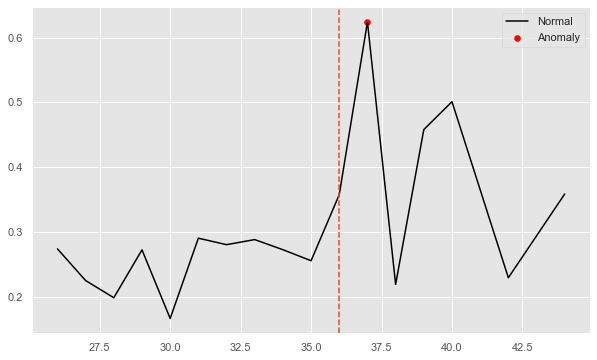

In [58]:
detect_anomalies('Phosphate', shallow, yr={2019}, month={7,8,9,10})

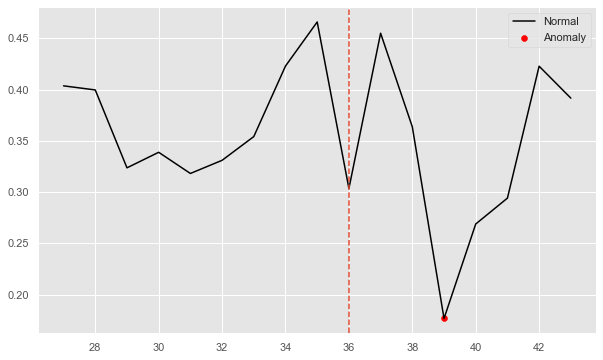

In [59]:
detect_anomalies('Phosphate', shallow, yr={2017}, month={7,8,9,10})

## Check with prokaryotic community

In [60]:
files = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/20**/dada2_output_exported/feature-table.tsv')
def load_df(filenames):
    ftables = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t', header=None)
        #df1 = df.iloc[1:]
        ftables.append(df)
    return ftables

In [61]:
#load all metadata and concatenate them into one dataframe
ftables = load_df(files)
ftables = pd.concat(ftables, axis=1)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,

In [62]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(year=all):
    if year == all:
        table_list = glob.glob('{0}/*/dada2_output/table_filt_contam.qza'.format('/Users/Diana/Documents/escuela/phd/ch2/bb_data'))
        print("Found all yearly tables")
        
    else:
        table_list = glob.glob('{0}/'+year+'/dada2_output/table_filt_contam.qza'.format('/Users/Diana/Documents/escuela/phd/ch2/bb_data'))
        print("Found all yearly tables")
        
    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')
            

            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            df['sample_name'] = df['sample_name'].str.replace('-', '.')
            dataframes.append(df)
            
            # Adding table_id, forward and reverse trim columns
            #df['table_id'] = str(table_path.split('/')[-3]) #add a table_id column
            #df['forward_trim'], df['reverse_trim'] = df['table_id'].str.split('R', 1).str
            #df['forward_trim'] = df['forward_trim'].map(lambda x: x.lstrip('F'))
            #df["forward_trim"] = pd.to_numeric(df["forward_trim"])
            #df["reverse_trim"] = pd.to_numeric(df["reverse_trim"])

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df

In [63]:
def merge_metadata(df):
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'sampleid'}, inplace=True)

    all_md['sampleid'] = all_md['sampleid'].str.replace('_', '.')
    merged = pd.merge(tables,all_md, on='sampleid', how='outer') #all_md is the metadata file
    merged = merged[merged.feature_frequency != 0]
    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [64]:
def pick_metadata(merged, depth='all', size_fraction='both', year='all', R='all', F='all', txsubset = 'all'):
#make df of features/composition+run+comm

    depth = depth
    year = year
    size_fraction = size_fraction
    txsubset = txsubset
        
    files = glob.glob('{0}/20**/taxa*/classification/*/data/taxonomy.tsv'.format('/Users/Diana/Documents/escuela/phd/ch2/bb_data'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        taxos.append(tax)
        
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    taxos = taxos.drop_duplicates()

    separated = merged.merge(taxos, how='left', on='feature_id') #merged excludes features of frequency = 0
    separated = separated.drop_duplicates()
    
    if depth != 'all':
        separated = separated[separated["depth"] == depth]
    if size_fraction != 'both':
        separated = separated[separated["size_fraction"] == size_fraction]

    
    
    
    #separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    #separated['ratio'] = separated['feature_frequency']/(separated['total'])
    #separated_taxonomies = separated.copy()
    
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    #separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return separated

In [65]:
df = consolidate_tables(year=all)

Found all yearly tables
Successfully saved all tables.


In [66]:
merged = merge_metadata(df)

Set up metadata ...
Saved merged_asvs_metadata.tsv


In [67]:
separated = pick_metadata(merged)

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


In [68]:
copy_of = separated.copy()

In [69]:
copy_of[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = copy_of['Taxon'].str.split('; ', expand=True)

In [70]:
copy_of

sampleid                        feature_id  feature_frequency    year    date  weekn  depth depth_code date_depth  [DNA]ng/uL  A260/280 extraction_date extracted_by Sequenced IMR_n  elutin_volume nifH MetaG     new_id notes  elution_volume Unnamed: 15  16S V6V8\nIMR # Notes  BR Working Code (Top of Tube) Label on side of Tube H2O Vol Filtered size_code IMR # - V4V5 IMR # - 18S  Elution volume  Correct Week # Sequencing Code\nBBYear.WeekDepthSize Freezer Box Aliquots  [DNA]ng/ul Freezer Box (1.5mL)  Filtration Volume (DNA)  sample_code month_name  month   day time_string_x time_string_y  julian_day    scan  temperature  conductivity  oxygenVoltage  fluorescence   unknown     pH       PSAR  salinity  theta  sigmaTheta   oxygen  scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic     time_string_time  season mission_descriptor  event_id  sample_id  latitude  \
0        BB14.10A  6388564e4b25815b40d34be01eb2c574              102.0  2014.0  05-Mar   10.0    1.0          A   03.05.1m         4.5      1.97      May 6 2014          NaN       yes   NaN          100.0  NaN   NaN   BB14.10A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Mar    3.0   5.0    2014-03-05    2014-03-05        64.0  1970.0       0.3580      0.581948         2.5917        2.8321 -0.065100    NaN  237.59000   29.3043    NaN     23.4968  7.61853    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2014-03-05 13:29:16  Spring          18VA14667       9.0   387992.0   44.6917   
1        BB14.10A  6388564e4b25815b40d34be01eb2c574              102.0  2014.0  05-Mar   10.0    1.0          A   03.05.1m         4.5      1.97      May 6 2014          NaN       yes   NaN          100.0  NaN   NaN   BB14.10A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Mar    3.0   5.0    2014-03-05    2014-03-05        64.0  1906.0       0.3693      0.582096         2.5922        2.8311  0.045077    NaN  184.84000   29.3014    NaN     23.4940  7.61141    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2014-03-05 13:29:16  Spring          18VA14667       9.0   387992.0   44.6917   
2        BB14.10A  fd5eeee9dda082827512f461eae9139e               17.0  2014.0  05-Mar   10.0    1.0          A   03.05.1m         4.5      1.97      May 6 2014          NaN       yes   NaN          100.0  NaN   NaN   BB14.10A   NaN             NaN         NaN              NaN   NaN                            NaN                   NaN              NaN       NaN          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN         NaN                 NaN                       NaN         NaN        Mar    3.0   5.0    2014-03-05    2014-03-05        64.0  1970.0       0.3580      0.581948         2.5917        2.8321 -0.065100    NaN  237.59000   29.3043    NaN     23.4968  7.61853    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2014-03-05 13:29:16  Spring          18VA14667       9.0   387992.0   44.6917   
3        BB14.10A  fd5eeee9dda0828275

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



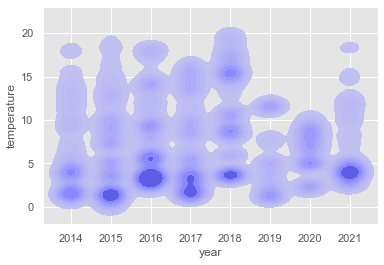

In [73]:
res = sns.kdeplot(copy_of['year'],copy_of['temperature'],color='blue',shade=True)
plt.show()

In [74]:
copy_of.groupby('sampleid')['feature_id'].nunique()

sampleid
BB10.20BL      0
BB14.10A     202
BB14.10B     210
BB14.10C     197
BB14.10D     277
            ... 
BB21.9CS       0
BB21.9DL       0
BB21.9DS       0
BB2140CL       0
BB216AL        0
Name: feature_id, Length: 2553, dtype: int64

In [75]:
#check for columns with missing values
copy_of.isnull().any()

sampleid             False
feature_id            True
feature_frequency     True
year                  True
date                  True
                     ...  
Class                 True
Order                 True
Family                True
Genus                 True
Species               True
Length: 111, dtype: bool

In [76]:
y2014=copy_of[copy_of.year==2014]
y2015=copy_of[copy_of.year==2015]
y2016=copy_of[copy_of.year==2016]
y2017=copy_of[copy_of.year==2017]
y2018=copy_of[copy_of.year==2018]
y2019=copy_of[copy_of.year==2019]
y2020=copy_of[copy_of.year==2020]
y2021=copy_of[copy_of.year==2021]

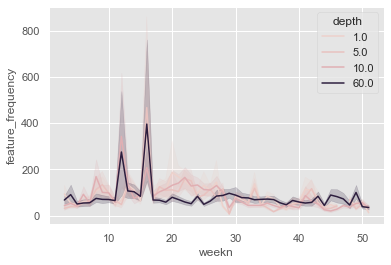

In [77]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2014, hue="depth")
plt.show()

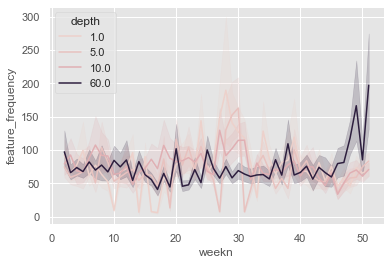

In [78]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2015, hue="depth")
plt.show()

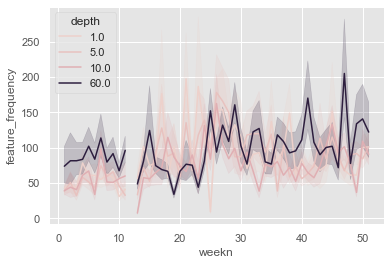

In [79]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2016, hue="depth")
plt.show()

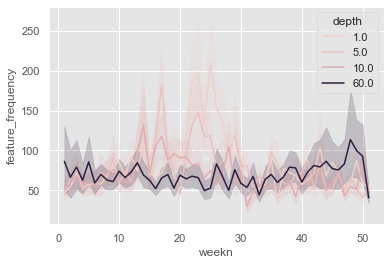

In [80]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2017, hue="depth")
plt.show()

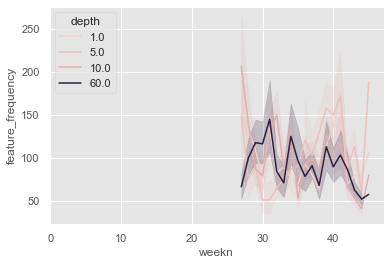

In [88]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2018, hue="depth")
plt.show()

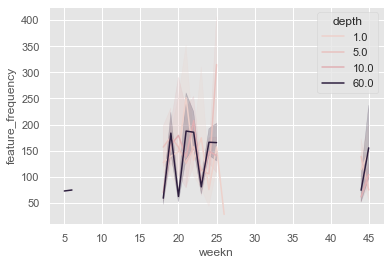

In [89]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2019, hue="depth")
plt.show()

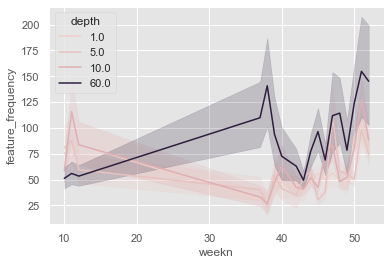

In [90]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2020, hue="depth")
plt.show()

In [92]:
y2020

sampleid                        feature_id  feature_frequency    year    date  weekn  depth depth_code date_depth  [DNA]ng/uL  A260/280 extraction_date extracted_by Sequenced IMR_n  elutin_volume nifH MetaG     new_id notes  elution_volume Unnamed: 15  16S V6V8\nIMR # Notes  BR Working Code (Top of Tube) Label on side of Tube H2O Vol Filtered size_code IMR # - V4V5 IMR # - 18S  Elution volume  Correct Week # Sequencing Code\nBBYear.WeekDepthSize Freezer Box Aliquots  [DNA]ng/ul Freezer Box (1.5mL)  Filtration Volume (DNA)  sample_code month_name  month   day time_string_x time_string_y  julian_day    scan  temperature  conductivity  oxygenVoltage  fluorescence  unknown     pH      PSAR  salinity   theta  sigmaTheta  oxygen  scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic     time_string_time  season mission_descriptor  event_id  sample_id  latitude  \
417590  BB20.10AL  dfe084ed2a4be66cd40b30864f3009ec               23.0  2020.0  04-Mar   10.0    1.0          A        NaN         NaN      1.59      2022-08-02         Anna       NaN   NaN            NaN  NaN   NaN  BB20.10AL   NaN           100.0         NaN              NaN   NaN                            NaN                   NaN              NaN         L          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN        33.4               Box 1                     450.0         NaN        Mar    3.0   4.0    2020-03-04    2020-03-04        64.0  2418.0       2.7027      0.616937         2.7104        6.0385      NaN  8.107  23.07200   28.9971  2.7027     23.1184  8.3901    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2020-03-04 13:07:07  Spring                NaN       NaN        NaN       NaN   
417591  BB20.10AL  dfe084ed2a4be66cd40b30864f3009ec               23.0  2020.0  04-Mar   10.0    1.0          A        NaN         NaN      1.59      2022-08-02         Anna       NaN   NaN            NaN  NaN   NaN  BB20.10AL   NaN           100.0         NaN              NaN   NaN                            NaN                   NaN              NaN         L          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN        33.4               Box 1                     450.0         NaN        Mar    3.0   4.0    2020-03-04    2020-03-04        64.0  2424.0       2.6952      0.617006         2.7018        6.1939      NaN  8.105  23.10800   29.0072  2.6951     23.1270  8.3055    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2020-03-04 13:07:07  Spring                NaN       NaN        NaN       NaN   
417592  BB20.10AL  82232a2660c8053be0084a589189e007               54.0  2020.0  04-Mar   10.0    1.0          A        NaN         NaN      1.59      2022-08-02         Anna       NaN   NaN            NaN  NaN   NaN  BB20.10AL   NaN           100.0         NaN              NaN   NaN                            NaN                   NaN              NaN         L          NaN         NaN             NaN             NaN                                   NaN         NaN      NaN        33.4               Box 1                     450.0         NaN        Mar    3.0   4.0    2020-03-04    2020-03-04        64.0  2418.0       2.7027      0.616937         2.7104        6.0385      NaN  8.107  23.07200   28.9971  2.7027     23.1184  8.3901    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2020-03-04 13:07:07  Spring                NaN       NaN        NaN       NaN   
417593  BB20.10AL  82232a2660c8053be0084a5891

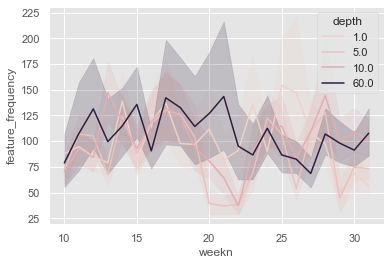

In [91]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2021, hue="depth")
plt.show()

In [81]:
import missingno as msno

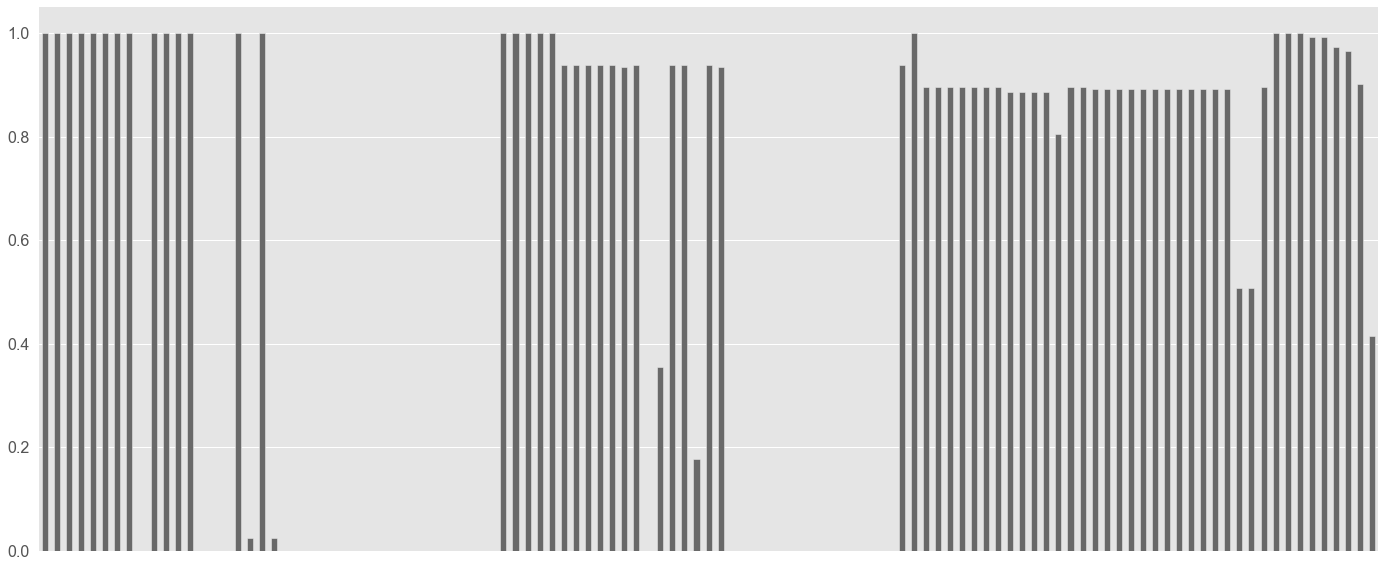

In [87]:
msno.bar(y2016)

In [311]:
salinity = shallow[['Weekn', 'temperature', "Year"]].copy()

In [313]:
salinity = salinity[salinity['temperature'].notna()]

In [314]:
salinity2014 = salinity[salinity.Year == 2019]
salinity2014 = salinity2014.drop(columns=['Year'])
salinity2014 = salinity2014.set_index(['Weekn'])

In [315]:
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(salinity2014.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

In [316]:
salinity2014

temperature
Weekn             
2.0       2.151417
3.0       2.205233
4.0       1.592067
5.0       1.875233
6.0       1.943050
...            ...
47.0      8.668567
48.0      7.817367
49.0      6.801833
50.0      6.959300
51.0      5.872850

[48 rows x 1 columns]

In [317]:
salinity2014['anomaly'] = model.predict(data)

KeyError: "None of [Index(['salinity'], dtype='object')] are in the [columns]"

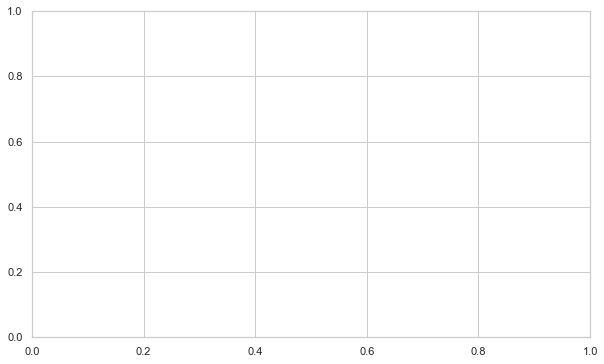

In [318]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = salinity2014.loc[salinity2014['anomaly'] == -1, ['salinity']] #anomaly
ax.plot(salinity2014.index, salinity2014['salinity'], color='black', label = 'Normal')
ax.scatter(a.index,a['salinity'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [253]:
fig = px.line(deep, x="Weekn", y="salinity", color='Year')
fig.show()

In [254]:
fig = px.line(deep, x="Weekn", y="Nitrate", color='Year')
fig.show()

In [38]:
all_md

sampleid  Year    Date  Weekn  Depth Depth_Code Sample date  \
0      BB14.3A  2014  15-Jan      3      1          A    01.15.1m   
1      BB14.3B  2014  15-Jan      3      5          B    01.15.5m   
2      BB14.3C  2014  15-Jan      3     10          C   01.15.10m   
3      BB14.3D  2014  15-Jan      3     60          D   01.15.60m   
4      BB14.4A  2014  23-Jan      4      1          A    01.23.1m   
...        ...   ...     ...    ...    ...        ...         ...   
2223  BB16.50D  2016  14-Dec     50     60          D         NaN   
2224  BB16.51A  2016  21-Dec     51      1          A         NaN   
2225  BB16.51B  2016  21-Dec     51      5          B         NaN   
2226  BB16.51C  2016  21-Dec     51     10          C         NaN   
2227  BB16.51D  2016  21-Dec     51     60          D         NaN   

      [DNA] (ng/uL)  260/280 Extraction Date  ... HPLC_CHLC12  HPLC_CHLC3  \
0               NaN      NaN             NaN  ...       0.000         0.0   
1               NaN      NaN             NaN  ...       0.023         0.0   
2               NaN      NaN             NaN  ...       0.042         0.0   
3               NaN      NaN             NaN  ...       0.000         0.0   
4               NaN      NaN             NaN  ...       0.000         0.0   
...             ...      ...             ...  ...         ...         ...   
2223           11.6      NaN      2017-01-23  ...         NaN         NaN   
2224           14.3      NaN      2017-01-23  ...         NaN         NaN   
2225           11.2      NaN      2017-01-23  ...         NaN         NaN   
2226           28.8      NaN      2017-03-06  ...         NaN         NaN   
2227           18.3      NaN      2017-03-06  ...         NaN         NaN   

     HPLC_DIADINOX HPLC_DIATOX HPLC_FUCOX  HPLC_HEX19 HPLC_PERID HPLC_ZEA  \
0              0.0         0.0      0.129         0.0        0.0      0.0   
1              0.0         0.0      0.145         0.0        0.0      0.0   
2              0.0         0.0      0.000         0.0        0.0      0.0   
3              0.0         0.0      0.000         0.0        0.0      0.0   
4              0.0         0.0      0.000         0.0        0.0      0.0   
...            ...         ...        ...         ...        ...      ...   
2223           NaN         NaN        NaN         NaN        NaN      NaN   
2224           NaN         NaN        NaN         NaN        NaN      NaN   
2225           NaN         NaN        NaN         NaN        NaN      NaN   
2226           NaN         NaN        NaN         NaN        NaN      NaN   
2227           NaN         NaN        NaN         NaN        NaN      NaN   

        POC   PON  
0       NaN   NaN  
1     206.1  27.2  
2       NaN   NaN  
3     514.8  75.3  
4       NaN   NaN  
...     ...   ...  
2223    NaN   NaN  
2224    NaN   NaN  
2225    NaN   NaN  
2226    NaN   NaN  
2227    NaN   NaN  

[2228 rows x 100 columns]

In [43]:
print(all_md['month'].to_string(index=False))

  01
  01
  01
  01
  01
  01
  01
  01
  01
  01
  01
  01
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  12
  12
  12
  12
  12
  12
  12
  12
  12
  12
  12
  12
 NaN
 NaN
 NaN
 NaN


In [31]:
all_md

sampleid  Year    Date  Weekn  Depth Depth_Code Sample date  \
0      BB14.3A  2014  15-Jan      3      1          A    01.15.1m   
1      BB14.3B  2014  15-Jan      3      5          B    01.15.5m   
2      BB14.3C  2014  15-Jan      3     10          C   01.15.10m   
3      BB14.3D  2014  15-Jan      3     60          D   01.15.60m   
4      BB14.4A  2014  23-Jan      4      1          A    01.23.1m   
...        ...   ...     ...    ...    ...        ...         ...   
2223  BB16.50D  2016  14-Dec     50     60          D         NaN   
2224  BB16.51A  2016  21-Dec     51      1          A         NaN   
2225  BB16.51B  2016  21-Dec     51      5          B         NaN   
2226  BB16.51C  2016  21-Dec     51     10          C         NaN   
2227  BB16.51D  2016  21-Dec     51     60          D         NaN   

      [DNA] (ng/uL)  260/280 Extraction Date  ... HPLC_CHLC12  HPLC_CHLC3  \
0               NaN      NaN             NaN  ...       0.000         0.0   
1               NaN      NaN             NaN  ...       0.023         0.0   
2               NaN      NaN             NaN  ...       0.042         0.0   
3               NaN      NaN             NaN  ...       0.000         0.0   
4               NaN      NaN             NaN  ...       0.000         0.0   
...             ...      ...             ...  ...         ...         ...   
2223           11.6      NaN      2017-01-23  ...         NaN         NaN   
2224           14.3      NaN      2017-01-23  ...         NaN         NaN   
2225           11.2      NaN      2017-01-23  ...         NaN         NaN   
2226           28.8      NaN      2017-03-06  ...         NaN         NaN   
2227           18.3      NaN      2017-03-06  ...         NaN         NaN   

     HPLC_DIADINOX HPLC_DIATOX HPLC_FUCOX  HPLC_HEX19 HPLC_PERID HPLC_ZEA  \
0              0.0         0.0      0.129         0.0        0.0      0.0   
1              0.0         0.0      0.145         0.0        0.0      0.0   
2              0.0         0.0      0.000         0.0        0.0      0.0   
3              0.0         0.0      0.000         0.0        0.0      0.0   
4              0.0         0.0      0.000         0.0        0.0      0.0   
...            ...         ...        ...         ...        ...      ...   
2223           NaN         NaN        NaN         NaN        NaN      NaN   
2224           NaN         NaN        NaN         NaN        NaN      NaN   
2225           NaN         NaN        NaN         NaN        NaN      NaN   
2226           NaN         NaN        NaN         NaN        NaN      NaN   
2227           NaN         NaN        NaN         NaN        NaN      NaN   

        POC   PON  
0       NaN   NaN  
1     206.1  27.2  
2       NaN   NaN  
3     514.8  75.3  
4       NaN   NaN  
...     ...   ...  
2223    NaN   NaN  
2224    NaN   NaN  
2225    NaN   NaN  
2226    NaN   NaN  
2227    NaN   NaN  

[2228 rows x 100 columns]

In [32]:
all_md.Year.unique()

array(['2014', '2015', '2017', '2019', '2021', '2020', '2018', '2016'],
      dtype=object)

In [ ]:
fig = px.line(depth1, x="Weekn", y="temperature", color='Year', )
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [103]:
for index, row in dfo_md.iterrows():
    dfo_md['week_n'] = datetime.date(dfo_md['year_time'], dfo_md['month_time'], dfo_md['day_time']).isocalendar()[1]

time_string  year_time  month_time  day_time  julian_day  \
0       1999-05-05 12:48:21       1999           5         5         125   
1       1999-05-05 12:48:21       1999           5         5         125   
2       1999-05-05 12:48:21       1999           5         5         125   
3       1999-05-05 12:48:21       1999           5         5         125   
4       1999-05-05 12:48:21       1999           5         5         125   
...                     ...        ...         ...       ...         ...   
170924  2023-05-24 11:57:12       2023           5        24         144   
170925  2023-05-24 11:57:12       2023           5        24         144   
170926  2023-05-24 11:57:12       2023           5        24         144   
170927  2023-05-24 11:57:12       2023           5        24         144   
170928  2023-05-24 11:57:12       2023           5        24         144   

           scan  pressure  temperature  conductivity  oxygenVoltage  ...  \
0        2623.0       1.0       7.7017           NaN            NaN  ...   
1        2629.0       1.5       7.3615           NaN            NaN  ...   
2        2635.0       2.0       7.2588           NaN            NaN  ...   
3        2640.0       2.5       6.5228           NaN            NaN  ...   
4        2644.0       3.0       5.3546           NaN            NaN  ...   
...         ...       ...          ...           ...            ...  ...   
170924  14241.0      69.0       3.2369      2.851717         1.8235  ...   
170925  14266.0      69.5       3.2371      2.851766         1.8173  ...   
170926  14291.0      70.0       3.2371      2.851796         1.8138  ...   
170927  14316.0      70.5       3.2373      2.851825         1.8109  ...   
170928  14479.0      71.0       3.2379      2.851891         1.8052  ...   

        oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  depth  \
0                    NaN   0.17271        NaN          NaN   NaN    NaN   
1                    NaN   0.00506        NaN          NaN   NaN    NaN   
2                    NaN   0.03027        NaN          NaN   NaN    NaN   
3                    NaN   0.11686        NaN          NaN   NaN    NaN   
4                    NaN   0.15878        NaN          NaN   NaN    NaN   
...                  ...       ...        ...          ...   ...    ...   
170924               NaN       NaN        NaN          NaN   NaN    NaN   
170925               NaN       NaN        NaN          NaN   NaN    NaN   
170926               NaN       NaN        NaN          NaN   NaN    NaN   
170927               NaN       NaN        NaN          NaN   NaN    NaN   
170928               NaN       NaN        NaN          NaN   NaN    NaN   

        fluorometer  par  flagArchaic  week_n  
0               NaN  NaN          NaN      24  
1               NaN  NaN          NaN      24  
2               NaN  NaN          NaN      24  
3               NaN  NaN          NaN      24  
4               NaN  NaN          NaN      24  
...             ...  ...          ...     ...  
170924          NaN  NaN          NaN      24  
170925          NaN  NaN          NaN      24  
170926          NaN  NaN          NaN      24  
170927          NaN  NaN          NaN      24  
170928          NaN  NaN          NaN      24  

[170929 rows x 33 columns]

In [58]:
df

sepal_length  sepal_width  petal_length  petal_width    species  \
0             5.1          3.5           1.4          0.2     setosa   
1             4.9          3.0           1.4          0.2     setosa   
2             4.7          3.2           1.3          0.2     setosa   
3             4.6          3.1           1.5          0.2     setosa   
4             5.0          3.6           1.4          0.2     setosa   
..            ...          ...           ...          ...        ...   
145           6.7          3.0           5.2          2.3  virginica   
146           6.3          2.5           5.0          1.9  virginica   
147           6.5          3.0           5.2          2.0  virginica   
148           6.2          3.4           5.4          2.3  virginica   
149           5.9          3.0           5.1          1.8  virginica   

     species_id  
0             1  
1             1  
2             1  
3             1  
4             1  
..          ...  
145           3  
146           3  
147           3  
148           3  
149           3  

[150 rows x 6 columns]

In [60]:
all_md.columns.values 

array(['sampleid', 'Year', 'Date', 'Weekn', 'Depth', 'Depth_Code',
       'Sample date', '[DNA] (ng/uL)', '260/280', 'Extraction Date',
       'Sequenced', 'Elution volume', 'nifH', 'MetaG', 'Extracted By',
       'A260/280', 'IMR #', 'Notes', 'BR Working Code (Top of Tube)',
       'Label on side of Tube', '16S V6V8\nIMR #', 'H2O Vol Filtered',
       'Correct Week #', 'Size_Code',
       'Sequencing Code\nBBYear.WeekDepthSize', 'Extracted by',
       'IMR # - V4V5', 'IMR # - 18S', 'Aliquots', 'Freezer Box',
       'Tube Label BBYear.WeekDepthSize', 'Filtration Volume (DNA) ',
       'Elution Volume', 'Freezer Box (1.5mL)', 'Month', 'month_time_x',
       'day_time_x', 'time_string', 'year_time', 'month_time_y',
       'day_time_y', 'julian_day', 'scan', 'temperature', 'conductivity',
       'oxygenVoltage', 'fluorescence', 'unknown', 'pH', 'PSAR',
       'salinity', 'theta', 'sigmaTheta', 'oxygen', 'scan2',
       'fluorescence2', 'turbidity', 'oxygenCurrent', 'oxygenTemperature',
  

In [80]:
df2 = all_md[['temperature', 'Chlorophyll A', 'Nitrate', 'Phosphate', 'Silicate', 'Salinity', 'Year']]

In [81]:
df2

temperature  Chlorophyll A  Nitrate  Phosphate  Silicate  Salinity  Year
0          3.6047           0.61     9.00       0.82     15.92     27.02  2014
1          3.4460           0.49     8.13       0.91     11.56     28.87  2014
2          3.3400           0.55     7.82       0.97     10.17     29.52  2014
3          5.2532           0.06    16.65       3.34     34.31     31.23  2014
4          1.0389           0.64     8.39       1.00     11.72     27.97  2014
...           ...            ...      ...        ...       ...       ...   ...
2223       5.4582            NaN      NaN        NaN       NaN       NaN  2016
2224       3.6150            NaN      NaN        NaN       NaN       NaN  2016
2225       5.0736            NaN      NaN        NaN       NaN       NaN  2016
2226       5.2547            NaN      NaN        NaN       NaN       NaN  2016
2227       5.4371            NaN      NaN        NaN       NaN       NaN  2016

[2228 rows x 7 columns]

In [84]:
bio_niskin[bio_niskin.isna().any(axis=1)]

mission_descriptor  event_id    sample_id  latitude  longitude  year  \
0             18VA92667         1  19920100101   44.6917   -63.6417  1992   
1             18VA92667         1  19920100102   44.6917   -63.6417  1992   
2             18VA92667         1  19920100103   44.6917   -63.6417  1992   
3             18VA92667         2  19920100201   44.6917   -63.6417  1992   
4             18VA92667         2  19920100202   44.6917   -63.6417  1992   
...                 ...       ...          ...       ...        ...   ...   
5894          18VA22667        46       490134   44.6937   -63.6403  2022   
5896          18VA22667        47       490140   44.6937   -63.6403  2022   
5898          18VA22667        47       490138   44.6937   -63.6403  2022   
5900          18VA22667        48       490144   44.6937   -63.6403  2022   
5902          18VA22667        48       490142   44.6937   -63.6403  2022   

      month  day  time  depth  ...  HPLC_CHLC12  HPLC_CHLC3  HPLC_DIADINOX  \
0         1    8  1230   1.00  ...          NaN         NaN            NaN   
1         1    8  1230   5.00  ...          NaN         NaN            NaN   
2         1    8  1230  10.00  ...          NaN         NaN            NaN   
3         1   15  1230   1.00  ...          NaN         NaN            NaN   
4         1   15  1230   5.00  ...          NaN         NaN            NaN   
...     ...  ...   ...    ...  ...          ...         ...            ...   
5894     12    7  1305  10.39  ...        0.062       0.023          0.021   
5896     12   14  1259   1.99  ...        0.066       0.000          0.027   
5898     12   14  1259  10.23  ...        0.056       0.000          0.021   
5900     12   21  1300   1.63  ...        0.073       0.000          0.024   
5902     12   21  1300  10.28  ...        0.039       0.000          0.000   

      HPLC_DIATOX  HPLC_FUCOX  HPLC_HEX19  HPLC_PERID  HPLC_ZEA  POC  PON  
0             NaN         NaN         NaN         NaN       NaN  NaN  NaN  
1             NaN         NaN         NaN         NaN       NaN  NaN  NaN  
2             NaN         NaN         NaN         NaN       NaN  NaN  NaN  
3             NaN         NaN         NaN         NaN       NaN  NaN  NaN  
4             NaN         NaN         NaN         NaN       NaN  NaN  NaN  
...           ...         ...         ...         ...       ...  ...  ...  
5894          0.0       0.231         0.0       0.000       0.0  NaN  NaN  
5896          0.0       0.157         0.0       0.047       0.0  NaN  NaN  
5898          0.0       0.141         0.0       0.041       0.0  NaN  NaN  
5900          0.0       0.147         0.0       0.048       0.0  NaN  NaN  
5902          0.0       0.107         0.0       0.000       0.0  NaN  NaN  

[4242 rows x 32 columns]

In [64]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

df = df2
features = ['pH','Temperature', 'temperature', 'Chlorophyll A', 'Nitrate', 'Phosphate', 'Silicate', 'Salinity']
X = df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['Year'])

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [3]:
#restrict to only years of interest 2019
dfo_md_14 = dfo_md[dfo_md.year_time == 2014]
dfo_md_14.loc[:,'year'] = "BB14" #add this column to match with metadata for QIIME2

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
dfo_14 = dfo_md_14.copy()

In [5]:
#restrict to only pressures 1,5,10,60
dfo_pressure_1 = dfo_14[dfo_14.pressure == 1.0]
dfo_pressure_1.loc[:,'depth_code'] = "A"

dfo_pressure_5 = dfo_14[dfo_14.pressure == 5.0]
dfo_pressure_5.loc[:,'depth_code'] = "B"

dfo_pressure_10 = dfo_14[dfo_14.pressure == 10.0]
dfo_pressure_10.loc[:,'depth_code'] = "C"

dfo_pressure_60 = dfo_14[dfo_14.pressure == 60.0]
dfo_pressure_60.loc[:,'depth_code'] = "D"

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [6]:
dfo_14 = pd.concat([dfo_pressure_1,dfo_pressure_5,dfo_pressure_10,dfo_pressure_60])

In [7]:
dfo_14 = dfo_14.sort_values(by="time_string")
dfo_14

time_string  year_time  month_time  day_time  julian_day  \
111155  2014-01-08 13:37:15       2014           1         8           8   
111163  2014-01-08 13:37:15       2014           1         8           8   
111273  2014-01-08 13:37:15       2014           1         8           8   
111173  2014-01-08 13:37:15       2014           1         8           8   
111397  2014-01-15 13:08:32       2014           1        15          15   
...                     ...        ...         ...       ...         ...   
117987  2014-12-10 13:09:03       2014          12        10         344   
118127  2014-12-17 13:08:48       2014          12        17         351   
118119  2014-12-17 13:08:48       2014          12        17         351   
118137  2014-12-17 13:08:48       2014          12        17         351   
118237  2014-12-17 13:08:48       2014          12        17         351   

          scan  pressure  temperature  conductivity  oxygenVoltage  ...  \
111155  1578.0       1.0       1.7707      0.600621         2.3087  ...   
111163  1992.0       5.0       2.2427      0.613212         2.3184  ...   
111273  3052.0      60.0       5.1876      0.708615         0.8887  ...   
111173  2097.0      10.0       2.5279      0.620612         2.2989  ...   
111397  5224.0      60.0       5.2532      0.708860         0.9694  ...   
...        ...       ...          ...           ...            ...  ...   
117987  1976.0       1.0       5.5452      0.662988         1.9814  ...   
118127  2581.0       5.0       6.0816      0.676788         2.1796  ...   
118119  2879.0       1.0          NaN           NaN            NaN  ...   
118137  2657.0      10.0       6.0927      0.694786         2.1654  ...   
118237  3426.0      60.0       4.9517      0.703909         0.8047  ...   

        unknown2  altimeter  sigmaTheta2  VOLT  depth  fluorometer  par  \
111155       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
111163       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
111273       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
111173       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
111397       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
...          ...        ...          ...   ...    ...          ...  ...   
117987       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
118127       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
118119       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
118137       NaN        NaN          NaN   NaN    NaN          NaN  NaN   
118237       NaN        NaN          NaN   NaN    NaN          NaN  NaN   

        flagArchaic  year  depth_code  
111155          NaN  BB14           A  
111163          NaN  BB14           B  
111273          NaN  BB14           D  
111173          NaN  BB14           C  
111397          NaN  BB14           D  
...             ...   ...         ...  
117987          NaN  BB14           A  
118127          NaN  BB14           B  
118119          NaN  BB14           A  
118137          NaN  BB14           C  
118237          NaN  BB14           D  

[206 rows x 34 columns]

In [9]:
dfo_14.shape

(206, 34)

In [ ]:
dfo_19 = dfo_19.reset_index()

In [10]:
dfo_19.loc[dfo_19['month_time'] == 2]

index          time_string  year_time  month_time  day_time  julian_day  \
16  146368  2019-02-06 13:19:04       2019           2         6          37   
17  146478  2019-02-06 13:19:04       2019           2         6          37   
18  146360  2019-02-06 13:19:04       2019           2         6          37   
19  146378  2019-02-06 13:19:04       2019           2         6          37   
20  146514  2019-02-14 13:20:48       2019           2        14          45   
21  146614  2019-02-14 13:20:48       2019           2        14          45   
22  146504  2019-02-14 13:20:48       2019           2        14          45   
23  146496  2019-02-14 13:20:48       2019           2        14          45   
24  146642  2019-02-20 13:22:19       2019           2        20          51   
25  146652  2019-02-20 13:22:19       2019           2        20          51   
26  146634  2019-02-20 13:22:19       2019           2        20          51   
27  146766  2019-02-27 13:25:06       2019           2        27          58   
28  146866  2019-02-27 13:25:06       2019           2        27          58   
29  146756  2019-02-27 13:25:06       2019           2        27          58   
30  146748  2019-02-27 13:25:06       2019           2        27          58   

      scan  pressure  temperature  conductivity  ...  unknown2  altimeter  \
16  2621.0       5.0       1.9352      0.620368  ...       NaN        NaN   
17  3515.0      60.0       4.9195      0.705999  ...       NaN        NaN   
18  2525.0       1.0       1.9152      0.619204  ...       NaN        NaN   
19  2700.0      10.0       1.9629      0.625336  ...       NaN        NaN   
20  3052.0      10.0       1.3398      0.618472  ...       NaN        NaN   
21  3853.0      60.0       2.8491      0.663177  ...       NaN        NaN   
22  2965.0       5.0       1.3045      0.617243  ...       NaN        NaN   
23  2908.0       1.0       0.8288      0.599134  ...       NaN        NaN   
24  2532.0       5.0       1.1553      0.615689  ...       NaN        NaN   
25  2616.0      10.0       1.4078      0.622687  ...       NaN        NaN   
26   239.0       1.0       0.7546      0.563542  ...       NaN        NaN   
27  2824.0      10.0       0.9898      0.617986  ...       NaN        NaN   
28  3672.0      60.0       2.5443      0.656907  ...       NaN        NaN   
29  2747.0       5.0       0.9811      0.617774  ...       NaN        NaN   
30  1734.0       1.0       0.9266      0.582170  ...       NaN        NaN   

    sigmaTheta2  VOLT  depth  fluorometer  par  flagArchaic  year  depth_code  
16          NaN   NaN    NaN          NaN  NaN          NaN  BB19           B  
17          NaN   NaN    NaN          NaN  NaN          NaN  BB19           D  
18          NaN   NaN    NaN          NaN  NaN          NaN  BB19           A  
19          NaN   NaN    NaN          NaN  NaN          NaN  BB19           C  
20          NaN   NaN    NaN          NaN  NaN          NaN  BB19           C  
21          NaN   NaN    NaN          NaN  NaN          NaN  BB19           D  
22          NaN   NaN    NaN          NaN  NaN          NaN  BB19           B  
23          NaN   NaN    NaN          NaN  NaN          NaN  BB19           A  
24          NaN   NaN    NaN          NaN  NaN          NaN  BB19           B  
25          NaN   NaN    NaN          NaN  NaN          NaN  BB19           C  
26          NaN   NaN    NaN          NaN  NaN          NaN  BB19           A  
27          NaN   NaN    NaN          NaN  NaN          NaN  BB19           C  
28          NaN   NaN    NaN          NaN  NaN          NaN  BB19           D  
29          NaN   NaN    NaN          NaN  NaN          NaN  BB19           B  
30          NaN   NaN    NaN          NaN  NaN          NaN  BB19           A  

[15 rows x 35 columns]

In [26]:
dfo_14.columns

Index(['time_string', 'year_time', 'month_time', 'day_time', 'julian_day',
       'scan', 'pressure', 'temperature', 'conductivity', 'oxygenVoltage',
       'fluorescence', 'unknown', 'pH', 'PSAR', 'salinity', 'theta',
       'sigmaTheta', 'oxygen', 'scan2', 'fluorescence2', 'turbidity',
       'oxygenCurrent', 'oxygenTemperature', 'oxygenSaturation', 'unknown2',
       'altimeter', 'sigmaTheta2', 'VOLT', 'depth', 'fluorometer', 'par',
       'flagArchaic', 'year', 'depth_code'],
      dtype='object')

In [12]:
dfo_19.loc[26.5] = 'Nan', 'Nan', 2019, 2, 20, 51, 'Nan', 60.0, 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan','Nan', 'Nan', 'Nan', 'Nan', 'Nan','Nan', 'Nan', 'Nan', 'Nan', 'Nan','Nan', 'Nan', 'Nan', 'Nan', 'Nan','BB19', 'D' #insert a column for the missing sample

In [12]:
dfo_14 = dfo_14.sort_index().reset_index(drop=True)

In [13]:
#add week number
week = np.arange(2,52)
week = np.repeat(week, 4)

In [15]:
dfo_14['week'] = week

ValueError: Length of values (200) does not match length of index (206)

In [24]:
dfo_14

time_string  year_time  month_time  day_time  julian_day    scan  \
0    2014-01-08 13:37:15       2014           1         8           8  1578.0   
1    2014-01-08 13:37:15       2014           1         8           8  1992.0   
2    2014-01-08 13:37:15       2014           1         8           8  2097.0   
3    2014-01-08 13:37:15       2014           1         8           8  3052.0   
4    2014-01-15 13:08:32       2014           1        15          15  4189.0   
..                   ...        ...         ...       ...         ...     ...   
201  2014-12-10 13:09:03       2014          12        10         344  3000.0   
202  2014-12-17 13:08:48       2014          12        17         351  2879.0   
203  2014-12-17 13:08:48       2014          12        17         351  2581.0   
204  2014-12-17 13:08:48       2014          12        17         351  2657.0   
205  2014-12-17 13:08:48       2014          12        17         351  3426.0   

     pressure  temperature  conductivity  oxygenVoltage  ...  unknown2  \
0         1.0       1.7707      0.600621         2.3087  ...       NaN   
1         5.0       2.2427      0.613212         2.3184  ...       NaN   
2        10.0       2.5279      0.620612         2.2989  ...       NaN   
3        60.0       5.1876      0.708615         0.8887  ...       NaN   
4         1.0       3.6047      0.593479         2.4356  ...       NaN   
..        ...          ...           ...            ...  ...       ...   
201      60.0       4.9001      0.702908         0.8680  ...       NaN   
202       1.0          NaN           NaN            NaN  ...       NaN   
203       5.0       6.0816      0.676788         2.1796  ...       NaN   
204      10.0       6.0927      0.694786         2.1654  ...       NaN   
205      60.0       4.9517      0.703909         0.8047  ...       NaN   

     altimeter  sigmaTheta2  VOLT  depth  fluorometer  par  flagArchaic  year  \
0          NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
1          NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
2          NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
3          NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
4          NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
..         ...          ...   ...    ...          ...  ...          ...   ...   
201        NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
202        NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
203        NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
204        NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   
205        NaN          NaN   NaN    NaN          NaN  NaN          NaN  BB14   

     depth_code  
0             A  
1             B  
2             C  
3             D  
4             A  
..          ...  
201           D  
202           A  
203           B  
204           C  
205           D  

[206 rows x 34 columns]

In [33]:
#how to join them:

#We'll make a new list to be our new column.
new_labels = []

#we can iterate through rows with this.
for _, row in dfo_14.iterrows():
    #we can get the column value of each row by indexing on the column name
    year = row['year']
    depth_code = row['depth_code']
    week = row['week']
    #we use string formatting here to make a new label
    new_label = "{0}-{1}{2}".format(year, week, depth_code)
    #add the new label to the list
    new_labels.append(new_label)
#this will make a new column in the df called 'NewLabel' with the values
dfo_14['name'] = new_labels
dfo_14

time_string  week  year_time  month_time  day_time  julian_day  \
0    2014-01-08 13:37:15     1       2014           1         8           8   
1    2014-01-08 13:37:15     1       2014           1         8           8   
2    2014-01-08 13:37:15     1       2014           1         8           8   
3    2014-01-08 13:37:15     1       2014           1         8           8   
4    2014-01-15 13:08:32     2       2014           1        15          15   
..                   ...   ...        ...         ...       ...         ...   
201  2014-12-10 13:09:03    51       2014          12        10         344   
202  2014-12-17 13:08:48    52       2014          12        17         351   
203  2014-12-17 13:08:48    52       2014          12        17         351   
204  2014-12-17 13:08:48    52       2014          12        17         351   
205  2014-12-17 13:08:48    52       2014          12        17         351   

       scan  pressure  temperature  conductivity  ...  altimeter  sigmaTheta2  \
0    1578.0       1.0       1.7707      0.600621  ...        NaN          NaN   
1    1992.0       5.0       2.2427      0.613212  ...        NaN          NaN   
2    2097.0      10.0       2.5279      0.620612  ...        NaN          NaN   
3    3052.0      60.0       5.1876      0.708615  ...        NaN          NaN   
4    4189.0       1.0       3.6047      0.593479  ...        NaN          NaN   
..      ...       ...          ...           ...  ...        ...          ...   
201  3000.0      60.0       4.9001      0.702908  ...        NaN          NaN   
202  2879.0       1.0          NaN           NaN  ...        NaN          NaN   
203  2581.0       5.0       6.0816      0.676788  ...        NaN          NaN   
204  2657.0      10.0       6.0927      0.694786  ...        NaN          NaN   
205  3426.0      60.0       4.9517      0.703909  ...        NaN          NaN   

     VOLT  depth  fluorometer  par  flagArchaic  year  depth_code      name  
0     NaN    NaN          NaN  NaN          NaN  BB14           A   BB14-1A  
1     NaN    NaN          NaN  NaN          NaN  BB14           B   BB14-1B  
2     NaN    NaN          NaN  NaN          NaN  BB14           C   BB14-1C  
3     NaN    NaN          NaN  NaN          NaN  BB14           D   BB14-1D  
4     NaN    NaN          NaN  NaN          NaN  BB14           A   BB14-2A  
..    ...    ...          ...  ...          ...   ...         ...       ...  
201   NaN    NaN          NaN  NaN          NaN  BB14           D  BB14-51D  
202   NaN    NaN          NaN  NaN          NaN  BB14           A  BB14-52A  
203   NaN    NaN          NaN  NaN          NaN  BB14           B  BB14-52B  
204   NaN    NaN          NaN  NaN          NaN  BB14           C  BB14-52C  
205   NaN    NaN          NaN  NaN          NaN  BB14           D  BB14-52D  

[206 rows x 36 columns]

In [37]:
#how to join them:

#We'll make a new list to be our new column.
new_labels = []

#we can iterate through rows with this.
for _, row in bb_md.iterrows():
    #we can get the column value of each row by indexing on the column name
    depth_code = row['Depth_Code']
    week = row['Week#']
    #we use string formatting here to make a new label
    new_label = "BB19-{1}{2}".format(year, week, depth_code)
    #add the new label to the list
    new_labels.append(new_label)
#this will make a new column in the df called 'NewLabel' with the values
bb_md['name'] = new_labels
bb_md

sampleid  Year    Date  Week#  Depth Depth_Code    Sample   \
0     BB14-3A  2014  15-Jan      3      1          A   01.15.1m   
1     BB14-3B  2014  15-Jan      3      5          B   01.15.5m   
2     BB14-3C  2014  15-Jan      3     10          C  01.15.10m   
3     BB14-3D  2014  15-Jan      3     60          D  01.15.60m   
4     BB14-4A  2014  23-Jan      4      1          A   01.23.1m   
..        ...   ...     ...    ...    ...        ...        ...   
191  BB14-50D  2014  10-Dec     50     60          D  12.10.60m   
192  BB14-51A  2014  17-Dec     51      1          A   12.17.1m   
193  BB14-51B  2014  17-Dec     51      5          B   12.17.5m   
194  BB14-51C  2014  17-Dec     51     10          C  12.17.10m   
195  BB14-51D  2014  17-Dec     51     60          D  12.17.60m   

     Concentration (ng/uL)  260/280  260/230 Date Extracted Sequenced  \
0                      NaN      NaN      NaN            NaN       yes   
1                      NaN      NaN      NaN            NaN       yes   
2                      NaN      NaN      NaN            NaN       yes   
3                      NaN      NaN      NaN            NaN       yes   
4                      NaN      NaN      NaN            NaN       yes   
..                     ...      ...      ...            ...       ...   
191                    NaN      NaN      NaN            NaN       yes   
192                    NaN      NaN      NaN            NaN       yes   
193                    NaN      NaN      NaN            NaN       yes   
194                    NaN      NaN      NaN            NaN       yes   
195                    NaN      NaN      NaN            NaN       yes   

     Elution volume     NewID  nifH  MetaG Month      name  
0               NaN   BB14-3A   NaN    NaN   Jan   BB19-3A  
1               NaN   BB14-3B   NaN    NaN   Jan   BB19-3B  
2               NaN   BB14-3C   NaN    NaN   Jan   BB19-3C  
3               NaN   BB14-3D   NaN    NaN   Jan   BB19-3D  
4               NaN   BB14-4A   NaN    NaN   Jan   BB19-4A  
..              ...       ...   ...    ...   ...       ...  
191             NaN  BB14-50D   NaN    NaN   Dec  BB19-50D  
192             NaN  BB14-51A   NaN    NaN   Dec  BB19-51A  
193             NaN  BB14-51B   NaN    NaN   Dec  BB19-51B  
194             NaN  BB14-51C   NaN    NaN   Dec  BB19-51C  
195             NaN  BB14-51D   NaN    NaN   Dec  BB19-51D  

[196 rows x 18 columns]

In [31]:
dfo_14 = dfo_metadata_y14.copy()

In [28]:
dfo_14.to_csv('dfo_metadata_y14.csv', index=False)

In [38]:
#merge 2 metadata files
metadata_bb = pd.merge(bb_md, dfo_14, on = 'name',how='outer')
metadata_bb

sampleid    Year    Date  Week#  Depth Depth_Code    Sample   \
0    BB14-3A  2014.0  15-Jan    3.0    1.0          A   01.15.1m   
1    BB14-3B  2014.0  15-Jan    3.0    5.0          B   01.15.5m   
2    BB14-3C  2014.0  15-Jan    3.0   10.0          C  01.15.10m   
3    BB14-3D  2014.0  15-Jan    3.0   60.0          D  01.15.60m   
4    BB14-4A  2014.0  23-Jan    4.0    1.0          A   01.23.1m   
..       ...     ...     ...    ...    ...        ...        ...   
397      NaN     NaN     NaN    NaN    NaN        NaN        NaN   
398      NaN     NaN     NaN    NaN    NaN        NaN        NaN   
399      NaN     NaN     NaN    NaN    NaN        NaN        NaN   
400      NaN     NaN     NaN    NaN    NaN        NaN        NaN   
401      NaN     NaN     NaN    NaN    NaN        NaN        NaN   

     Concentration (ng/uL)  260/280  260/230  ... unknown2 altimeter  \
0                      NaN      NaN      NaN  ...      NaN       NaN   
1                      NaN      NaN      NaN  ...      NaN       NaN   
2                      NaN      NaN      NaN  ...      NaN       NaN   
3                      NaN      NaN      NaN  ...      NaN       NaN   
4                      NaN      NaN      NaN  ...      NaN       NaN   
..                     ...      ...      ...  ...      ...       ...   
397                    NaN      NaN      NaN  ...      NaN       NaN   
398                    NaN      NaN      NaN  ...      NaN       NaN   
399                    NaN      NaN      NaN  ...      NaN       NaN   
400                    NaN      NaN      NaN  ...      NaN       NaN   
401                    NaN      NaN      NaN  ...      NaN       NaN   

     sigmaTheta2 VOLT  depth  fluorometer par flagArchaic  year  depth_code  
0            NaN  NaN    NaN          NaN NaN         NaN   NaN         NaN  
1            NaN  NaN    NaN          NaN NaN         NaN   NaN         NaN  
2            NaN  NaN    NaN          NaN NaN         NaN   NaN         NaN  
3            NaN  NaN    NaN          NaN NaN         NaN   NaN         NaN  
4            NaN  NaN    NaN          NaN NaN         NaN   NaN         NaN  
..           ...  ...    ...          ...  ..         ...   ...         ...  
397          NaN  NaN    NaN          NaN NaN         NaN  BB14           D  
398          NaN  NaN    NaN          NaN NaN         NaN  BB14           A  
399          NaN  NaN    NaN          NaN NaN         NaN  BB14           B  
400          NaN  NaN    NaN          NaN NaN         NaN  BB14           C  
401          NaN  NaN    NaN          NaN NaN         NaN  BB14           D  

[402 rows x 53 columns]

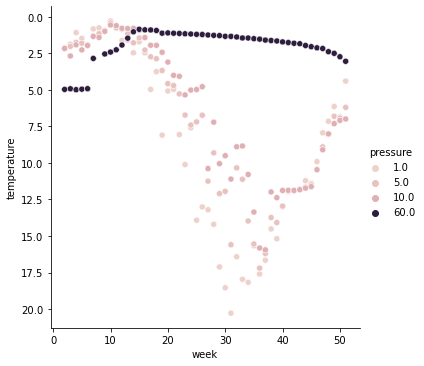

In [19]:
sns.relplot(data=metadata_bb, x="week", y="temperature", hue='pressure')

In [39]:
metadata_bb2 = metadata_bb.fillna(0)

In [40]:
metadata_bb2["week"] = pd.to_numeric(metadata_bb2["week"])

In [42]:
metadata_bb2["temperature"] = pd.to_numeric(metadata_bb2["temperature"])

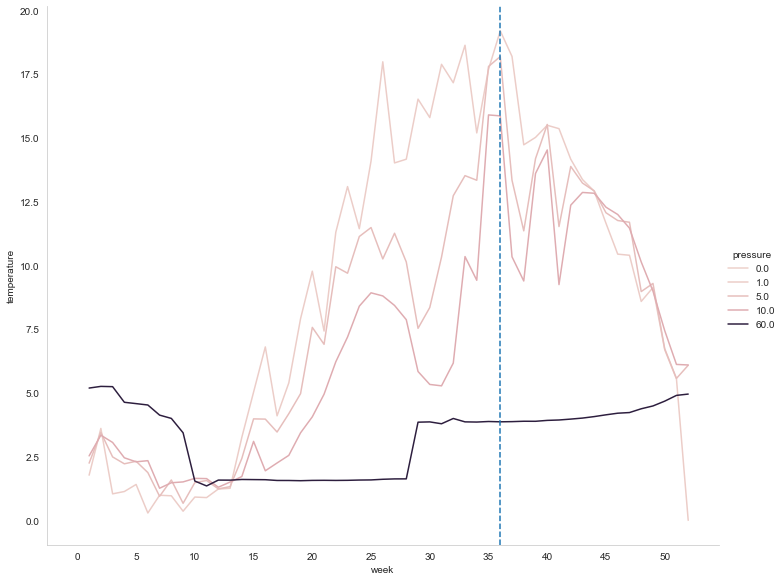

In [43]:
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.relplot(
    data=metadata_bb2, kind="line",
    x="week", y="temperature", hue="pressure", height = 8, aspect = 1.25
)
g.set(xticks=np.arange(0,52,5))
plt.axvline(36, ls='--')

In [22]:
metadata_bb

sampleid    Year    Date  Week #  Correct Week #  Depth(m) Depth code  \
0     BB19-2AL  2019.0  09-Jan     2.0             2.0       1.0          A   
1     BB19-2AS  2019.0  09-Jan     2.0             2.0       1.0          A   
2     BB19-2BL  2019.0  09-Jan     2.0             2.0       5.0          B   
3     BB19-2BS  2019.0  09-Jan     2.0             2.0       5.0          B   
4     BB19-2CL  2019.0  09-Jan     2.0             2.0      10.0          C   
..         ...     ...     ...     ...             ...       ...        ...   
401  BB19-51DS  2019.0  18-Dec    51.0            51.0      60.0          D   
402        NaN     NaN     NaN     NaN             NaN       NaN        NaN   
403        NaN     NaN     NaN     NaN             NaN       NaN        NaN   
404        NaN     NaN     NaN     NaN             NaN       NaN        NaN   
405        NaN     NaN     NaN     NaN             NaN       NaN        NaN   

    Size Code\n0.2um - S\n3um - L Tube Label\nBBYear.WeekDepthSize  \
0                               L                         BB19-2AL   
1                               S                         BB19-2AS   
2                               L                         BB19-2BL   
3                               S                         BB19-2BS   
4                               L                         BB19-2CL   
..                            ...                              ...   
401                             S                    BB19-DEC18 DS   
402                           NaN                              NaN   
403                           NaN                              NaN   
404                           NaN                              NaN   
405                           NaN                              NaN   

    Extraction Date  ... altimeter  sigmaTheta2 VOLT  depth  fluorometer  par  \
0       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
1       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
2       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
3       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
4       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
..              ...  ...       ...          ...  ...    ...          ...  ...   
401     Dec 14 2021  ...       NaN          NaN  NaN    NaN          NaN  NaN   
402             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   
403             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   
404             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   
405             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   

     flagArchaic  year depth_code  week  
0            NaN  BB19          A   2.0  
1            NaN  BB19          A   2.0  
2            NaN  BB19          B   2.0  
3            NaN  BB19          B   2.0  
4            NaN  BB19          C   2.0  
..           ...   ...        ...   ...  
401          NaN  BB19          D  51.0  
402          NaN  BB19          A  43.0  
403          NaN  BB19          D  43.0  
404          NaN  BB19          B  43.0  
405          NaN  BB19          C  43.0  

[406 rows x 66 columns]

In [23]:
biomtable19 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/dada2_output_270210_exported/table_from_biom.txt", sep='\t')
classification = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/taxa_270210/taxonomy.tsv", sep='\t')

In [63]:
biomtable14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2014/dada2_output_exported/feature-table.tsv", sep='\t')
classification14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2014/taxa/taxonomy.tsv", sep='\t')

In [64]:
biomtable14.rename({'#OTU ID': 'Feature ID'}, axis=1, inplace=True)

In [65]:
biomtable14

# Constructed from biom file
#OTU ID                          BB14-10A BB14-10B BB14-10C BB14-10D BB14-11A BB14-11B BB14-11C BB14-11D BB14-12A BB14-12B BB14-12C BB14-12D BB14-13A BB14-13B BB14-13C BB14-13D BB14-14A BB14-14B BB14-14C BB14-14D BB14-15A BB14-15B BB14-15C BB14-15D BB14-16A BB14-16B BB14-16C BB14-16D BB14-17A BB14-17B BB14-17C BB14-17D BB14-18A BB14-18B BB14-18C BB14-18D BB14-19A BB14-19B BB14-19C BB14-19D BB14-20A BB14-20B BB14-20C BB14-20D BB14-21A BB14-21B BB14-21C BB14-21D BB14-22A BB14-22B BB14-22C BB14-22D BB14-23A BB14-23B BB14-23C BB14-23D BB14-24A BB14-24B BB14-24C BB14-24D BB14-25A BB14-25B BB14-25C BB14-25D BB14-26A BB14-26B BB14-26C BB14-26D BB14-27A BB14-27B BB14-27C BB14-27D BB14-28A BB14-28B BB14-28C BB14-28D BB14-29A BB14-29B BB14-29C BB14-29D BB14-30A BB14-30B BB14-30C BB14-30D BB14-31A BB14-31B BB14-31C BB14-31D BB14-32A BB14-32B BB14-32C BB14-32D BB14-33A BB14-33B BB14-33C BB14-33D BB14-34A BB14-34B BB14-34C BB14-34D BB14-35A BB14-35B BB14-35C BB14-35D BB14-36A BB14-36B BB14-36C BB14-36D BB14-37A BB14-37B BB14-37C BB14-37D BB14-38A BB14-38B BB14-38C BB14-38D BB14-39A BB14-39B BB14-39C BB14-39D BB14-3A BB14-3B BB14-3C BB14-3D BB14-40A BB14-40B BB14-40C BB14-40D BB14-41A BB14-41B BB14-41C BB14-41D BB14-42A BB14-42B BB14-42C BB14-42D BB14-43A BB14-43B BB14-43C BB14-43D BB14-44A BB14-44B BB14-44C BB14-44D BB14-45A BB14-45B BB14-45C BB14-45D BB14-46A BB14-46B BB14-46C BB14-46D BB14-47C BB14-47D BB14-48A BB14-48B BB14-48C BB14-48D BB14-49A BB14-49B BB14-49C BB14-49D BB14-4A BB14-4B BB14-4C BB14-4D BB14-50A BB14-50B BB14-50C BB14-50D BB14-51A BB14-51B BB14-51C BB14-51D BB14-5A BB14-5B BB14-5C BB14-5D BB14-6A BB14-6B BB14-6C BB14-6D BB14-7A BB14-7B BB14-7C BB14-7D BB14-8A BB14-8B BB14-8C BB14-8D BB14-9A BB14-9B BB14-9C                      BB14-9D
79f3f51b584fe5e37cebc3b9f117c5ae 0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      13.0     6.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      6.0      0.0      0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0                              0.0
7012a87569ffdbc4422e4b6fe72ec59d 0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0    

In [62]:
meltedbiom = pd.melt(frame=biomtable14, id_vars = 'Feature ID', var_name = 'sampleid', value_name = 'Rel Abun')

AttributeError: 'NoneType' object has no attribute 'columns'

In [27]:
mergedmelty = pd.merge(meltedbiom, classification, on = 'Feature ID',how='inner')

In [28]:
merged = mergedmelty.set_index('Taxon')

In [29]:
merged = merged.drop(columns=['Confidence', 'Feature ID'])

In [30]:
merged

sampleid  Rel Abun
Taxon                                                                   
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18AL       0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18AS       0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18BL       0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18BS       0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18CL       0.0
...                                                        ...       ...
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43BS       0.0
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43CL       0.0
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43CS       0.0
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43DL       0.0
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43DS       0.0

[701610 rows x 2 columns]

In [31]:
merged.loc[:,'Total'] = merged.sum(axis=1)
merged

sampleid  Rel Abun  \
Taxon                                                                      
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18AL       0.0   
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18AS       0.0   
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18BL       0.0   
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18BS       0.0   
d__Bacteria; p__Proteobacteria; c__Gammaproteob...   BB19-18CL       0.0   
...                                                        ...       ...   
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43BS       0.0   
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43CL       0.0   
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43CS       0.0   
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43DL       0.0   
d__Bacteria; p__Desulfobacterota; c__Desulfurom...  BB19-a43DS       0.0   

                                                    Total  
Taxon                                                      
d__Bacteria; p__Proteobacteria; c__Gammaproteob...    0.0  
d__Bacteria; p__Proteobacteria; c__Gammaproteob...    0.0  
d__Bacteria; p__Proteobacteria; c__Gammaproteob...    0.0  
d__Bacteria; p__Proteobacteria; c__Gammaproteob...    0.0  
d__Bacteria; p__Proteobacteria; c__Gammaproteob...    0.0  
...                                                   ...  
d__Bacteria; p__Desulfobacterota; c__Desulfurom...    0.0  
d__Bacteria; p__Desulfobacterota; c__Desulfurom...    0.0  
d__Bacteria; p__Desulfobacterota; c__Desulfurom...    0.0  
d__Bacteria; p__Desulfobacterota; c__Desulfurom...    0.0  
d__Bacteria; p__Desulfobacterota; c__Desulfurom...    0.0  

[701610 rows x 3 columns]

In [32]:
groupedbytaxon = merged.groupby(['Taxon']).sum()

In [33]:
groupformelty = groupedbytaxon.reset_index()

In [34]:
totals = groupformelty[['Taxon', 'Total']]

In [35]:
top20 = groupedbytaxon.nlargest(20,'Total')

In [36]:
top5 = groupedbytaxon.nlargest(5, 'Total')

In [37]:
rare5 =  groupedbytaxon.nsmallest(5, 'Total')

In [38]:
rare5.index

Index(['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__uncultured; g__uncultured; s__uncultured_delta',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Cyclobacteriaceae; g__Fulvivirga; s__uncultured_Flexibacter',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Spirosomaceae; g__Arcicella',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__uncultured; s__uncultured_Bacteroidetes',
       'd__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Desulfuromonadia; f__Geopsychrobacteraceae; g__Desulfuromusa; s__uncultured_bacterium'],
      dtype='object', name='Taxon')

In [39]:
top20 = top20.drop(columns=['Total'])

In [40]:
top20T = top20.T
top20T['sampleid'] = top20T.index

In [41]:
top20T.columns

Index(['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Amylibacter',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidi

In [42]:
df_long.pivot_table(index=["sampleid"], 
                    columns='class', 
                    values='grade')

NameError: name 'df_long' is not defined

In [43]:
df_long.pivot_table(index=["student", "school"], 
                    columns='class', 
                    values='grade')

NameError: name 'df_long' is not defined

In [44]:
withmeta = pd.merge(top20T, metadata_bb, on = 'sampleid',how='inner')

In [45]:
withmetamelty = pd.merge(mergedmelty, metadata_bb, on='sampleid', how='inner')

In [46]:
withmetamelty = pd.merge (withmetamelty, totals, on = 'Taxon', how='inner')

In [47]:
withmetamelty

Feature ID    sampleid  Rel Abun  \
0       88504ccccf908bd07cad252b49564924   BB19-18AL       0.0   
1       88504ccccf908bd07cad252b49564924   BB19-18AS       0.0   
2       88504ccccf908bd07cad252b49564924   BB19-18BL       0.0   
3       88504ccccf908bd07cad252b49564924   BB19-18BS       0.0   
4       88504ccccf908bd07cad252b49564924   BB19-18CL       0.0   
...                                  ...         ...       ...   
701605  250a576e3788b3f444938c7b08afb2e3  BB19-a43BS       0.0   
701606  250a576e3788b3f444938c7b08afb2e3  BB19-a43CL       0.0   
701607  250a576e3788b3f444938c7b08afb2e3  BB19-a43CS       0.0   
701608  250a576e3788b3f444938c7b08afb2e3  BB19-a43DL       0.0   
701609  250a576e3788b3f444938c7b08afb2e3  BB19-a43DS       0.0   

                                                    Taxon  Confidence    Year  \
0       d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.939373  2019.0   
1       d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.939373  2019.0   
2       d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.939373  2019.0   
3       d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.939373  2019.0   
4       d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.939373  2019.0   
...                                                   ...         ...     ...   
701605  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.723322  2019.0   
701606  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.723322  2019.0   
701607  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.723322  2019.0   
701608  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.723322  2019.0   
701609  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.723322  2019.0   

          Date  Week #  Correct Week #  Depth(m)  ... sigmaTheta2 VOLT depth  \
0       01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
1       01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
2       01-May    18.0            18.0       5.0  ...         NaN  NaN   NaN   
3       01-May    18.0            18.0       5.0  ...         NaN  NaN   NaN   
4       01-May    18.0            18.0      10.0  ...         NaN  NaN   NaN   
...        ...     ...             ...       ...  ...         ...  ...   ...   
701605  23-Oct    42.0            43.0       5.0  ...         NaN  NaN   NaN   
701606  23-Oct    42.0            43.0      10.0  ...         NaN  NaN   NaN   
701607  23-Oct    42.0            43.0      10.0  ...         NaN  NaN   NaN   
701608  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   
701609  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   

       fluorometer  par  flagArchaic  year  depth_code  week  Total  
0              NaN  NaN          NaN  BB19           A  18.0  159.0  
1              NaN  NaN          NaN  BB19           A  18.0  159.0  
2              NaN  NaN          NaN  BB19           B  18.0  159.0  
3              NaN  NaN          NaN  BB19           B  18.0  159.0  
4              NaN  NaN          NaN  BB19           C  18.0  159.0  
...            ...  ...          ...   ...         ...   ...    ...  
701605         NaN  NaN          NaN  BB19           B  42.0  194.0  
701606         NaN  NaN          NaN  BB19           C  42.0  194.0  
701607         NaN  NaN          NaN  BB19           C  42.0  194.0  
701608         NaN  NaN          NaN  BB19           D  42.0  194.0  
701609         NaN  NaN          NaN  BB19           D  42.0  194.0  

[701610 rows x 71 columns]

In [48]:
top20 = ['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Amylibacter',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Planctomycetota; c__OM190; o__OM190; f__OM190; g__OM190; s__marine_metagenome',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae; g__SUP05_cluster',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Cryomorphaceae; g__uncultured',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Tenacibaculum',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Ulvibacter; s__uncultured_marine',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__NS5_marine_group',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Polaribacter',
       'd__Bacteria; p__Nitrospinota; c__Nitrospinia; o__Nitrospinales; f__Nitrospinaceae; g__LS-NOB',
       'd__Bacteria; p__Planctomycetota; c__Planctomycetes; o__Planctomycetales; f__Rubinisphaeraceae; g__Fuerstia; s__uncultured_bacterium',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__NS3a_marine_group']


In [49]:
top5 = ['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae']

In [50]:
mdtop20 = withmetamelty[withmetamelty['Taxon'].isin(top20)]

In [51]:
mdtop5 = withmetamelty[withmetamelty['Taxon'].isin(top5)]

In [44]:
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.relplot(
    data=mdtop5, kind="line",
    x="week", y="Rel Abun", hue="Taxon", height = 8, aspect = 1.25
)
g.set(xticks=np.arange(0,52,5))
plt.axvline(36, ls='--')

NameError: name 'mdtop5' is not defined

In [53]:
mdtop5

Feature ID    sampleid  Rel Abun  \
169260  8de78294559168d41a2f0ec6196bff4f   BB19-18AL      73.0   
169261  2462a5acc546029c7e21fd170d2a482e   BB19-18AL       0.0   
169262  51d6f4fcbee32cc1382a4e8a147f384e   BB19-18AL       0.0   
169263  f752e67ebf6c52d40f99164cef71911e   BB19-18AL       0.0   
169264  6339c9fdaf957a8ba7073ab06e76f910   BB19-18AL       0.0   
...                                  ...         ...       ...   
493306  fa31e148a4fa1a4dfce3b59a2d542b85  BB19-a43DL       8.0   
493307  71a33c961f2ca92f6ce97184fcb81f01  BB19-a43DL     914.0   
493308  a897667502a072da9c30e63c34547778  BB19-a43DS       0.0   
493309  fa31e148a4fa1a4dfce3b59a2d542b85  BB19-a43DS       0.0   
493310  71a33c961f2ca92f6ce97184fcb81f01  BB19-a43DS       0.0   

                                                    Taxon  Confidence    Year  \
169260  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.704028  2019.0   
169261  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.771751  2019.0   
169262  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.729820  2019.0   
169263  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.787688  2019.0   
169264  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.757582  2019.0   
...                                                   ...         ...     ...   
493306  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.735284  2019.0   
493307  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.999488  2019.0   
493308  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.980163  2019.0   
493309  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.735284  2019.0   
493310  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.999488  2019.0   

          Date  Week #  Correct Week #  Depth(m)  ... sigmaTheta2 VOLT depth  \
169260  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169261  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169262  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169263  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169264  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
...        ...     ...             ...       ...  ...         ...  ...   ...   
493306  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   
493307  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   
493308  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   
493309  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   
493310  23-Oct    42.0            43.0      60.0  ...         NaN  NaN   NaN   

       fluorometer  par  flagArchaic  year  depth_code  week     Total  
169260         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169261         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169262         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169263         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169264         NaN  NaN          NaN  BB19           A  18.0  312112.0  
...            ...  ...          ...   ...         ...   ...       ...  
493306         NaN  NaN          NaN  BB19           D  42.0  400813.0  
493307         NaN  NaN          NaN  BB19           D  42.0  400813.0  
493308         NaN  NaN          NaN  BB19           D  42.0  400813.0  
493309         NaN  NaN          NaN  BB19           D  42.0  400813.0  
493310         NaN  NaN          NaN  BB19           D  42.0  400813.0  

[9828 rows x 71 columns]

In [54]:
metadata_bb

sampleid    Year    Date  Week #  Correct Week #  Depth(m) Depth code  \
0     BB19-2AL  2019.0  09-Jan     2.0             2.0       1.0          A   
1     BB19-2AS  2019.0  09-Jan     2.0             2.0       1.0          A   
2     BB19-2BL  2019.0  09-Jan     2.0             2.0       5.0          B   
3     BB19-2BS  2019.0  09-Jan     2.0             2.0       5.0          B   
4     BB19-2CL  2019.0  09-Jan     2.0             2.0      10.0          C   
..         ...     ...     ...     ...             ...       ...        ...   
401  BB19-51DS  2019.0  18-Dec    51.0            51.0      60.0          D   
402        NaN     NaN     NaN     NaN             NaN       NaN        NaN   
403        NaN     NaN     NaN     NaN             NaN       NaN        NaN   
404        NaN     NaN     NaN     NaN             NaN       NaN        NaN   
405        NaN     NaN     NaN     NaN             NaN       NaN        NaN   

    Size Code\n0.2um - S\n3um - L Tube Label\nBBYear.WeekDepthSize  \
0                               L                         BB19-2AL   
1                               S                         BB19-2AS   
2                               L                         BB19-2BL   
3                               S                         BB19-2BS   
4                               L                         BB19-2CL   
..                            ...                              ...   
401                             S                    BB19-DEC18 DS   
402                           NaN                              NaN   
403                           NaN                              NaN   
404                           NaN                              NaN   
405                           NaN                              NaN   

    Extraction Date  ... altimeter  sigmaTheta2 VOLT  depth  fluorometer  par  \
0       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
1       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
2       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
3       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
4       JAN 18 2022  ...       NaN          NaN  NaN    NaN          NaN  NaN   
..              ...  ...       ...          ...  ...    ...          ...  ...   
401     Dec 14 2021  ...       NaN          NaN  NaN    NaN          NaN  NaN   
402             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   
403             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   
404             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   
405             NaN  ...       NaN          NaN  NaN    NaN          NaN  NaN   

     flagArchaic  year depth_code  week  
0            NaN  BB19          A   2.0  
1            NaN  BB19          A   2.0  
2            NaN  BB19          B   2.0  
3            NaN  BB19          B   2.0  
4            NaN  BB19          C   2.0  
..           ...   ...        ...   ...  
401          NaN  BB19          D  51.0  
402          NaN  BB19          A  43.0  
403          NaN  BB19          D  43.0  
404          NaN  BB19          B  43.0  
405          NaN  BB19          C  43.0  

[406 rows x 66 columns]

In [187]:
mdtop5.pressure.unique()

array([ 1.,  5., 10., 60., nan])

In [186]:
mdtop5['pressure'] = mdtop5['pressure'].replace('nan', 0.0)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [194]:
mdtop5_dA = mdtop5[mdtop5.depth_code == 'A']

In [195]:
fig = px.line(mdtop5_dA, x="week", y="Rel Abun", color='Taxon')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [203]:
fig = px.scatter(mdtop5_dA, x="week", y="temperature", color='Season')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [204]:
fig = px.scatter(mdtop5_dA, x="week", y="oxygen", color='Season')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [198]:
mdtop5_dA

Feature ID    sampleid  Rel Abun  \
169260  8de78294559168d41a2f0ec6196bff4f   BB19-18AL      73.0   
169261  2462a5acc546029c7e21fd170d2a482e   BB19-18AL       0.0   
169262  51d6f4fcbee32cc1382a4e8a147f384e   BB19-18AL       0.0   
169263  f752e67ebf6c52d40f99164cef71911e   BB19-18AL       0.0   
169264  6339c9fdaf957a8ba7073ab06e76f910   BB19-18AL       0.0   
...                                  ...         ...       ...   
493288  fa31e148a4fa1a4dfce3b59a2d542b85  BB19-a43AL       0.0   
493289  71a33c961f2ca92f6ce97184fcb81f01  BB19-a43AL    4507.0   
493290  a897667502a072da9c30e63c34547778  BB19-a43AS       0.0   
493291  fa31e148a4fa1a4dfce3b59a2d542b85  BB19-a43AS       0.0   
493292  71a33c961f2ca92f6ce97184fcb81f01  BB19-a43AS       6.0   

                                                    Taxon  Confidence    Year  \
169260  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.704028  2019.0   
169261  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.771751  2019.0   
169262  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.729820  2019.0   
169263  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.787688  2019.0   
169264  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    0.757582  2019.0   
...                                                   ...         ...     ...   
493288  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.735284  2019.0   
493289  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.999488  2019.0   
493290  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.980163  2019.0   
493291  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.735284  2019.0   
493292  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.999488  2019.0   

          Date  Week #  Correct Week #  Depth(m)  ... sigmaTheta2 VOLT depth  \
169260  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169261  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169262  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169263  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
169264  01-May    18.0            18.0       1.0  ...         NaN  NaN   NaN   
...        ...     ...             ...       ...  ...         ...  ...   ...   
493288  23-Oct    42.0            43.0       1.0  ...         NaN  NaN   NaN   
493289  23-Oct    42.0            43.0       1.0  ...         NaN  NaN   NaN   
493290  23-Oct    42.0            43.0       1.0  ...         NaN  NaN   NaN   
493291  23-Oct    42.0            43.0       1.0  ...         NaN  NaN   NaN   
493292  23-Oct    42.0            43.0       1.0  ...         NaN  NaN   NaN   

       fluorometer  par  flagArchaic  year  depth_code  week     Total  
169260         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169261         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169262         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169263         NaN  NaN          NaN  BB19           A  18.0  312112.0  
169264         NaN  NaN          NaN  BB19           A  18.0  312112.0  
...            ...  ...          ...   ...         ...   ...       ...  
493288         NaN  NaN          NaN  BB19           A  42.0  400813.0  
493289         NaN  NaN          NaN  BB19           A  42.0  400813.0  
493290         NaN  NaN          NaN  BB19           A  42.0  400813.0  
493291         NaN  NaN          NaN  BB19           A  42.0  400813.0  
493292         NaN  NaN          NaN  BB19           A  42.0  400813.0  

[2448 rows x 71 columns]

In [201]:
withmetamelty.to_csv('w_md_melted.csv', index=False)

In [68]:
withmeta.columns

Index(['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Amylibacter',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidi